<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#загрузка-данных" data-toc-modified-id="загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>загрузка данных</a></span></li><li><span><a href="#разделение-выборки" data-toc-modified-id="разделение-выборки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>разделение выборки</a></span></li><li><span><a href="#metrics" data-toc-modified-id="metrics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>metrics</a></span></li><li><span><a href="#Neuro-nets" data-toc-modified-id="Neuro-nets-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Neuro nets</a></span></li><li><span><a href="#Avg-of-3" data-toc-modified-id="Avg-of-3-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Avg of 3</a></span><ul class="toc-item"><li><span><a href="#__tfidf-models" data-toc-modified-id="__tfidf-models-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>__tfidf models</a></span></li><li><span><a href="#__atr-models" data-toc-modified-id="__atr-models-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>__atr models</a></span></li><li><span><a href="#Avg-model" data-toc-modified-id="Avg-model-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Avg model</a></span></li><li><span><a href="#--submit" data-toc-modified-id="--submit-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>--submit</a></span></li></ul></li><li><span><a href="#keras_weights" data-toc-modified-id="keras_weights-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>keras_weights</a></span></li></ul></div>

## загрузка данных

In [1]:
import pandas as pd
import numpy as np
import re
import unicodedata

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import InputLayer, Dense

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, AUC
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
import keras.backend as K

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE
from scipy import sparse as sp
from scipy.spatial.distance import cosine

from lightgbm import LGBMClassifier

from termcolor import colored

import random as r
import matplotlib.pyplot as plt

import warnings
import sys

import voting

In [2]:
warnings.filterwarnings('ignore')

In [3]:
RS = 42
BATCH_SIZE = 32

Загрузка данных

In [4]:
data = pd.read_parquet('e:\\ds\\hackaton\\joined_mod_3.parquet')
data.shape

(306540, 13)

Загрузка шаблонов

In [5]:
templator = pd.read_csv('e:\\ds\\hackaton\\results_df.csv', index_col='Unnamed: 0')
templator.shape

(306540, 3)

In [13]:
test_templator = pd.read_csv('e:\\ds\\hackaton\\test_results_df.csv')
test_templator.shape

(18084, 3)

Загрузка атрибутов

In [6]:
attr_train =  pd.read_parquet('e:\\ds\\hackaton\\train_attr_features_01.parquet')
attr_train.shape

(306540, 1453)

In [14]:
attr_test =  pd.read_parquet('e:\\ds\\hackaton\\test_attr_features_01.parquet')
attr_test.shape

(18084, 1452)

In [7]:
# только колонки с атрибутами
X_attr_cols = list(attr_train.columns[6:])

---

Функция очистки текста для tfidf

In [8]:
def clean_text(text):
    '''функция удалит все кроме английских букв, цифр, запятых(не окруженных пробелами), точек(не окруженных пробелами) и тире'''
    text = re.sub(r'[^a-zA-Z0-9.,-]', ' ', text) #тире убираем тоже, т.к. токенайзер разделяет слова по нему
#     text = re.sub(r'\b[a-zA-Z]+\b', '', text)
    text = re.sub(r'\s\.\s', ' ', text)
    text = re.sub(r'\s\,\s', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = text.strip(' ')
    return text

Очистка текста и выделение вотдельные столбцы для tfidf

In [9]:
data['tfidf_1'] = data['name'].apply(clean_text)
data['tfidf_2'] = data['name_2'].apply(clean_text)

---

In [ ]:
объединение с шаблонами

In [ ]:
data = pd.concat([data, templator], axis =1)
data.head(2)

объединение с атрибутами

In [ ]:
data = pd.concat([data, attr_train[X_attr_cols]], axis =1)
data.head(2)

In [12]:
del attr_train

Загрузка тестов

In [15]:
test_pairs = pd.read_parquet('e:\\ds\\hackaton\\test_pairs_2.parquet')
test_pairs.shape

(18084, 12)

Очистка текста и выделение вотдельные столбцы для tfidf

In [17]:
test_pairs['tfidf_1'] = test_pairs['name'].apply(clean_text)
test_pairs['tfidf_2'] = test_pairs['name_2'].apply(clean_text)

___

объединение с шаблонами

In [18]:
test_pairs = pd.concat([test_pairs, test_templator], axis =1)

объединение с атрибутами

In [19]:
test_pairs = pd.concat([test_pairs, attr_test[X_attr_cols]], axis =1)

In [20]:
del attr_test

---

Дополнительные категории

---3lvl
объединение мелких категорий в rest

In [21]:
cat3_counts = data['categories'].value_counts().to_dict()

In [22]:
data['categories'] = data['categories'].apply(lambda x: x if cat3_counts[x] > 500 else "rest")

In [23]:
train_categories = data['categories'].unique().tolist()
data['categories'].nunique()

69

In [24]:
test_pairs['categories'] = test_pairs['categories'].apply(lambda x: x if x in train_categories else "rest")
test_pairs['categories'].nunique()

65

--3lvl

In [27]:
cat3_counts = data['categories_2'].value_counts().to_dict()

In [28]:
data['categories_2'] = data['categories_2'].apply(lambda x: x if cat3_counts[x] > 500 else "rest")

In [29]:
train_categories_3lvl = data['categories_2'].unique().tolist()
data['categories_2'].nunique()

46

In [30]:
test_pairs['categories_2'] = test_pairs['categories_2'].apply(lambda x: x if x in train_categories_3lvl else "rest")
test_pairs['categories_2'].nunique()

46

Список всех категорий

In [ ]:
all_categories = data['categories'].unique().tolist()
len(all_categories)

Выделение фич и таргета

In [39]:
X = data.drop(columns=['target'])
y = data['target']

---

## разделение выборки

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS, stratify=data[['categories', 'target']])

In [41]:
del data
del X
del y

In [43]:
#масштабирование шаблонов
scaler = MinMaxScaler()
X_train[['similar','opposite','single']] = scaler.fit_transform(X_train[['similar','opposite','single']])
X_test[['similar','opposite','single']] = scaler.transform(X_test[['similar','opposite','single']])
test_pairs[['similar','opposite','single']] = scaler.transform(test_pairs[['similar','opposite','single']])

---

## metrics

In [63]:
def plot_history(history):
    loss_list = [s for s in history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.keys() if 'auc' in s and 'val' not in s]
    val_acc_list = [s for s in history.keys() if 'auc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history[l], 'b', label='Training loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history[l], 'g', label='Validation loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history[l], 'b', label='Training auc (' + str(format(history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history[l], 'g', label='Validation auc (' + str(format(history[l][-1],'.5f'))+')')

    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

In [64]:
minor_cats = ['Запчасти для ноутбуков',
'Зарядные устройства и док-станции',
'Расходник для печати',
'Смарт-часы',
'Кабели и переходники',
'Компьютер',
'Запчасти для смартфонов',
'Смартфоны, планшеты, мобильные телефоны']

In [65]:
def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)
    
    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            print(colored('{0} Precissions found'.format(0), 'red'))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
            if category in minor_cats:
                print(colored('pr-auc: {0:.5f}   Вес: {1:.5f}   {2}'.format(pr_auc_prec_level, counts[i]/len(categories), category), 'blue'))
            else:
                print(f"pr-auc: {pr_auc_prec_level:.5f}   Вес: {counts[i]/len(categories):.5f}   {category}")
        except ValueError:
            print(f"---------------   Вес: {counts[i]/len(categories):.5f}   {category}")
            pr_aucs.append(0)
        
    return np.average(pr_aucs, weights=weights)

In [73]:
def pr_auc_macro_prep(Y_true, y_pred):
    Y_true['scores'] = y_pred
    target = Y_true[['target','variantid1','variantid2']]
    pred = Y_true[['variantid1','variantid2', 'categories_2', 'scores']].rename(columns={'categories_2':'cat3_grouped'})
#     pred = Y_true[['variantid1','variantid2', 'categories', 'scores']].rename(columns={'categories':'cat3_grouped'})
    return target, pred

In [67]:
def submit_prep(Y_true, y_pred):
    Y_true['target'] = y_pred
    return Y_true[['variantid1','variantid2', 'target']]

---

___

## Neuro nets

In [340]:
tf.keras.backend.clear_session()

In [91]:
tf.config.run_functions_eagerly(True)

In [55]:
def sep_features_to_numpy(val):
    array_1 = np.array(val.main_pic_embeddings_resnet_v1.tolist())
    array_2 = np.array(val.main_pic_embeddings_resnet_v1_2.tolist())
    array_3 = np.array(val.name_bert_64.tolist())
    array_4 = np.array(val.name_bert_64_2.tolist())
    array_5 = np.array(val.similar.tolist())
    array_6 = np.array(val.opposite.tolist())
    array_7 = np.array(val.single.tolist())
    return array_1, array_2, array_3, array_4, array_5, array_6, array_7

In [56]:
def sep_mapping(img_vector_1, img_vector_2, bert_1, bert_2, similar, opposite, single, labels, ):
    return {'img_vec_1': img_vector_1, 
            'img_vec_2': img_vector_2,
            'bert_1': bert_1,
            'bert_2': bert_2,
            'sim': similar,
            'opp': opposite,
            'sngl': single,
           }, labels

In [57]:
def ds_create(X_tr, X_te, y_tr, y_te, cat):
    idx_train = indexes(X_tr, cat)
    cols = ['main_pic_embeddings_resnet_v1', 'name_bert_64', 'main_pic_embeddings_resnet_v1_2', 'name_bert_64_2', 'similar', 'opposite', 'single']
    train_sp_img_vector_1, train_sp_img_vector_2, train_sp_bert_1, train_sp_bert_2, tr_sim, tr_opp, tr_sngl = sep_features_to_numpy(X_tr.iloc[idx_train][cols])
    train_sp_labels = y_tr.iloc[idx_train].values
    train_sp_dataset = tf.data.Dataset.from_tensor_slices((train_sp_img_vector_1, 
                                              train_sp_img_vector_2, 
                                              train_sp_bert_1,
                                              train_sp_bert_2,
                                               tr_sim, tr_opp, tr_sngl,
                                              train_sp_labels))
    train_sp_dataset = train_sp_dataset.map(sep_mapping).cache()
    train_sp_dataset = train_sp_dataset.batch(BATCH_SIZE, drop_remainder = True).prefetch(tf.data.AUTOTUNE)
    
    idx_test = indexes(X_te, cat)
    test_sp_img_vector_1, test_sp_img_vector_2, test_sp_bert_1, test_sp_bert_2, te_sim, te_opp, te_sngl = sep_features_to_numpy(X_te.iloc[idx_test][cols])
    test_sp_labels = y_te.iloc[idx_test].values
    test_sp_dataset = tf.data.Dataset.from_tensor_slices((test_sp_img_vector_1, 
                                              test_sp_img_vector_2, 
                                              test_sp_bert_1,
                                              test_sp_bert_2,
                                              te_sim, te_opp, te_sngl,
                                              test_sp_labels))
    test_sp_dataset = test_sp_dataset.map(sep_mapping)
    test_sp_dataset = test_sp_dataset.batch(BATCH_SIZE, drop_remainder = False).prefetch(tf.data.AUTOTUNE)
    
    return train_sp_dataset, test_sp_dataset

In [187]:
# m = ds_create(X_train, X_test, y_train, y_test, 'Чехол')

In [58]:
def mm_models_creator(name):
    optimizer = Adam(learning_rate=0.01)
    loss = BinaryCrossentropy()
    acc = AUC()
    
    with tf.device('/device:GPU:0'):
        input_img_1 = tf.keras.layers.Input(shape=(128), name = 'img_vec_1')
        input_img_2 = tf.keras.layers.Input(shape=(128), name = 'img_vec_2')
        input_bert_1 = tf.keras.layers.Input(shape=(64), name = 'bert_1')
        input_bert_2 = tf.keras.layers.Input(shape=(64), name = 'bert_2')
        input_sim = tf.keras.layers.Input(shape=(1), name = 'sim')
        input_opp = tf.keras.layers.Input(shape=(1), name = 'opp')
        input_sngl = tf.keras.layers.Input(shape=(1), name = 'sngl')
    
    with tf.device('/device:GPU:0'):
        sp_concatenated_1 = keras.layers.Concatenate(name = 'conc_1')([input_img_1, input_bert_1])
        sp_output_1 = Dense(16, activation='relu')(sp_concatenated_1)
        sp_model_1 = tf.keras.Model(inputs=[input_img_1, input_bert_1], outputs = sp_output_1, name = name+'_model_1')
        
    with tf.device('/device:GPU:0'):
        sp_concatenated_2 = keras.layers.Concatenate(name = 'conc_2')([input_img_2, input_bert_2])
        sp_output_2 = Dense(16, activation='relu')(sp_concatenated_2)
        sp_model_2 = tf.keras.Model(inputs=[input_img_2, input_bert_2], outputs = sp_output_2, name = name+'_model_2')
        
    with tf.device('/device:GPU:0'):
        sp_concatenated_all = keras.layers.Concatenate(name = 'conc_all')([sp_model_1([input_img_1, input_bert_1]), 
                                                                        sp_model_2([input_img_2, input_bert_2]),
                                                                          input_sim, input_opp, input_sngl])
        sp_fc_1 = Dense(8, activation='relu')(sp_concatenated_all)
        sp_output = Dense(1, activation='sigmoid', name = 'output')(sp_fc_1)
        sp_model = tf.keras.Model(inputs=[input_img_1, input_bert_1, input_img_2, input_bert_2, input_sim, input_opp, input_sngl],
                               outputs = sp_output, name = name+'_model')
        sp_model.compile(optimizer=optimizer, loss=loss, metrics=acc)
    return sp_model

In [60]:
# англ названия категорий для имен сетей
all_categories_en = ['Surgeprotectorssplittersandextensioncords',
'PrintConsumable',
'Smartwatch',
'Batteriesandaccumulators',
'rest',
'UPS',
'Acousticsandspeakers',
'Computer',
'CCTV',
'Manualinputdevice',
'Videorecorder',
'Cablesandadapters',
'Case',
'Chargersanddockingstations',
'TVs',
'WiredandDECTphones',
'HarddrivesSSDsandNAS',
'Protectivefilmsandglasses',
'Backpackscasesbags',
'Headphonesandheadsets',
'Antennasandaccessories',
'Smartphonestabletsmobilephones',
'Camcorders',
'Computercases',
'RAM',
'Sparepartsforsmartphones',
'Monitorsandspareparts',
'Sparepartsforlaptops',
'Motherboard',
'Coolingsystemsforcomputers',
'Accessoriesforphotoandvideoequipment',
'Networkhardware',
'Powersupplies',
'Electronicmodules',
'Bracket',
'PrintersandMFPs',
'Opticaldevices',
'Memorycardsandflashdrives',
'Microphonesandaccessories',
'CPU',
'Mousepad',
'Videocardsandgraphicsaccelerators',
'Gameconsole',
'SmartHouse',
'Intercom',
'Officeequipment']


In [61]:
%%time

mm_models = {}
mm_models_ds = {}

for i, cat in enumerate(all_categories):
 
    mm_models_ds[cat] = ds_create(X_train, X_test, y_train, y_test, cat)
    mm_models[cat] = mm_models_creator(all_categories_en[i])
mm_models['type'] = 'keras'

CPU times: total: 22.6 s
Wall time: 43.5 s


1  from  55 /  Микроскоп
Epoch 1/10
40/40 [==============================] - 1s 19ms/step - loss: 0.4553 - auc: 0.8293 - val_loss: 0.4257 - val_auc: 0.8553
Epoch 2/10
40/40 [==============================] - 1s 17ms/step - loss: 0.4417 - auc: 0.8402 - val_loss: 0.4367 - val_auc: 0.8504
Epoch 3/10
40/40 [==============================] - 1s 17ms/step - loss: 0.4265 - auc: 0.8530 - val_loss: 0.4321 - val_auc: 0.8508


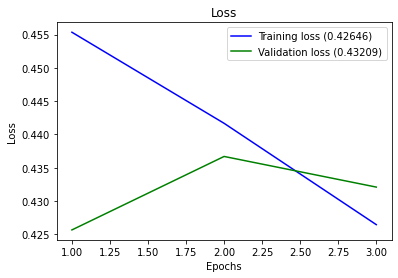

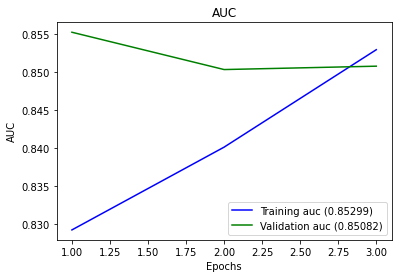

11/11 [==============================] - 0s 6ms/step
2  from  55 /  Зарядные устройства и док-станции
Epoch 1/10
179/179 [==============================] - 4s 18ms/step - loss: 0.6704 - auc_1: 0.6021 - val_loss: 0.6560 - val_auc_1: 0.6406
Epoch 2/10
179/179 [==============================] - 3s 16ms/step - loss: 0.6387 - auc_1: 0.6689 - val_loss: 0.6472 - val_auc_1: 0.6609
Epoch 3/10
179/179 [==============================] - 3s 15ms/step - loss: 0.6213 - auc_1: 0.6953 - val_loss: 0.6354 - val_auc_1: 0.6721
Epoch 4/10
179/179 [==============================] - 3s 16ms/step - loss: 0.6173 - auc_1: 0.7007 - val_loss: 0.6456 - val_auc_1: 0.6446
Epoch 5/10
179/179 [==============================] - 3s 16ms/step - loss: 0.6121 - auc_1: 0.7094 - val_loss: 0.6346 - val_auc_1: 0.6664
Epoch 6/10
179/179 [==============================] - 3s 15ms/step - loss: 0.6050 - auc_1: 0.7145 - val_loss: 0.6392 - val_auc_1: 0.6649
Epoch 7/10
179/179 [==============================] - 3s 15ms/step - loss: 0

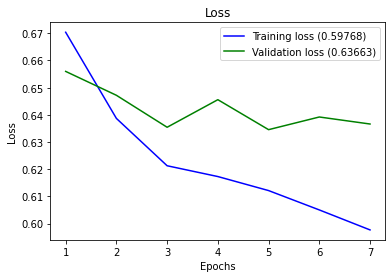

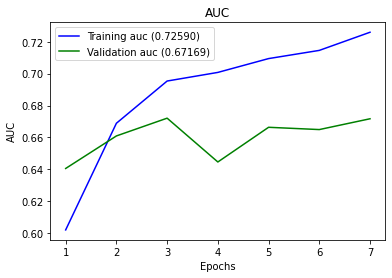

45/45 [==============================] - 0s 4ms/step
3  from  55 /  Принтеры и МФУ
Epoch 1/10
56/56 [==============================] - 2s 23ms/step - loss: 0.5939 - auc_2: 0.5274 - val_loss: 0.5799 - val_auc_2: 0.5745
Epoch 2/10
56/56 [==============================] - 1s 18ms/step - loss: 0.5821 - auc_2: 0.5689 - val_loss: 0.5727 - val_auc_2: 0.5984
Epoch 3/10
56/56 [==============================] - 1s 16ms/step - loss: 0.5730 - auc_2: 0.6105 - val_loss: 0.5770 - val_auc_2: 0.6123
Epoch 4/10
56/56 [==============================] - 1s 16ms/step - loss: 0.5696 - auc_2: 0.6180 - val_loss: 0.5710 - val_auc_2: 0.6240
Epoch 5/10
56/56 [==============================] - 1s 16ms/step - loss: 0.5635 - auc_2: 0.6363 - val_loss: 0.5658 - val_auc_2: 0.6278
Epoch 6/10
56/56 [==============================] - 1s 16ms/step - loss: 0.5567 - auc_2: 0.6541 - val_loss: 0.5709 - val_auc_2: 0.6278
Epoch 7/10
56/56 [==============================] - 1s 16ms/step - loss: 0.5499 - auc_2: 0.6722 - val_loss:

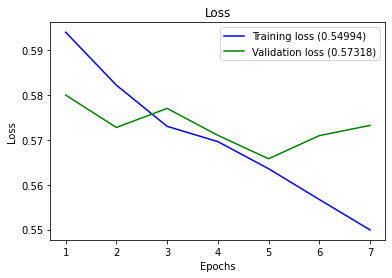

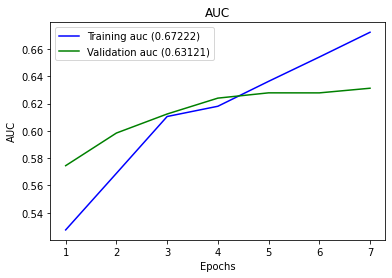

15/15 [==============================] - 0s 4ms/step
4  from  55 /  Защитная пленка
Epoch 1/10
75/75 [==============================] - 2s 20ms/step - loss: 0.3975 - auc_3: 0.5860 - val_loss: 0.3651 - val_auc_3: 0.6873
Epoch 2/10
75/75 [==============================] - 1s 16ms/step - loss: 0.3655 - auc_3: 0.6695 - val_loss: 0.3590 - val_auc_3: 0.6860
Epoch 3/10
75/75 [==============================] - 1s 16ms/step - loss: 0.3597 - auc_3: 0.6923 - val_loss: 0.3504 - val_auc_3: 0.6896
Epoch 4/10
75/75 [==============================] - 1s 16ms/step - loss: 0.3560 - auc_3: 0.7020 - val_loss: 0.3491 - val_auc_3: 0.6944
Epoch 5/10
75/75 [==============================] - 1s 16ms/step - loss: 0.3521 - auc_3: 0.7156 - val_loss: 0.3486 - val_auc_3: 0.6902
Epoch 6/10
75/75 [==============================] - 1s 16ms/step - loss: 0.3517 - auc_3: 0.7184 - val_loss: 0.3488 - val_auc_3: 0.6894
Epoch 7/10
75/75 [==============================] - 1s 16ms/step - loss: 0.3515 - auc_3: 0.7217 - val_loss

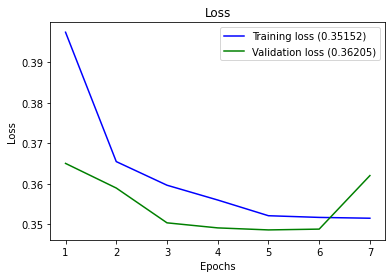

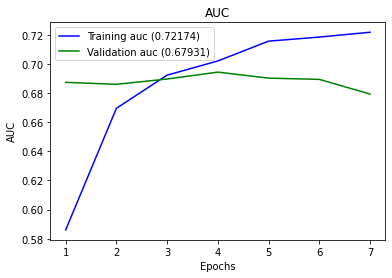

19/19 [==============================] - 0s 4ms/step
5  from  55 /  Смартфон
Epoch 1/10
934/934 [==============================] - 15s 16ms/step - loss: 0.5829 - auc_4: 0.7181 - val_loss: 0.5476 - val_auc_4: 0.7673
Epoch 2/10
934/934 [==============================] - 14s 15ms/step - loss: 0.5349 - auc_4: 0.7779 - val_loss: 0.5356 - val_auc_4: 0.7905
Epoch 3/10
934/934 [==============================] - 14s 15ms/step - loss: 0.5244 - auc_4: 0.7875 - val_loss: 0.5180 - val_auc_4: 0.8043
Epoch 4/10
934/934 [==============================] - 14s 15ms/step - loss: 0.5175 - auc_4: 0.7952 - val_loss: 0.5163 - val_auc_4: 0.8040
Epoch 5/10
934/934 [==============================] - 15s 16ms/step - loss: 0.5164 - auc_4: 0.7967 - val_loss: 0.5117 - val_auc_4: 0.8084
Epoch 6/10
934/934 [==============================] - 15s 16ms/step - loss: 0.5126 - auc_4: 0.8008 - val_loss: 0.5177 - val_auc_4: 0.8076
Epoch 7/10
934/934 [==============================] - 15s 16ms/step - loss: 0.5103 - auc_4: 0.8

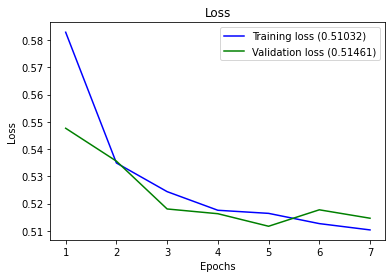

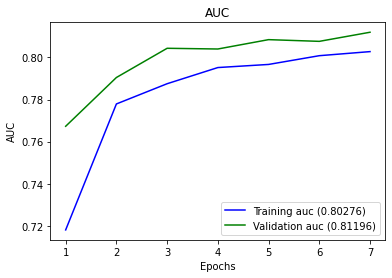

234/234 [==============================] - 1s 4ms/step
6  from  55 /  Жесткие диски, SSD и сетевые накопители
Epoch 1/10
170/170 [==============================] - 4s 17ms/step - loss: 0.6071 - auc_5: 0.6848 - val_loss: 0.5687 - val_auc_5: 0.7571
Epoch 2/10
170/170 [==============================] - 3s 15ms/step - loss: 0.5479 - auc_5: 0.7666 - val_loss: 0.5340 - val_auc_5: 0.7859
Epoch 3/10
170/170 [==============================] - 3s 15ms/step - loss: 0.4929 - auc_5: 0.8304 - val_loss: 0.4772 - val_auc_5: 0.8479
Epoch 4/10
170/170 [==============================] - 3s 15ms/step - loss: 0.4309 - auc_5: 0.8798 - val_loss: 0.4265 - val_auc_5: 0.8775
Epoch 5/10
170/170 [==============================] - 3s 15ms/step - loss: 0.3995 - auc_5: 0.8956 - val_loss: 0.4135 - val_auc_5: 0.8842
Epoch 6/10
170/170 [==============================] - 3s 15ms/step - loss: 0.3856 - auc_5: 0.9013 - val_loss: 0.4098 - val_auc_5: 0.8893
Epoch 7/10
170/170 [==============================] - 3s 15ms/step -

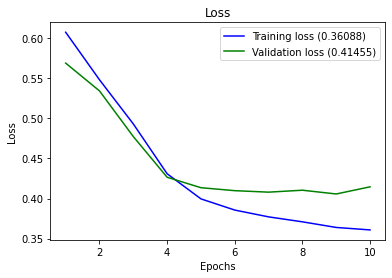

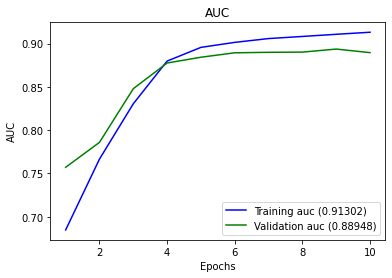

43/43 [==============================] - 0s 4ms/step
7  from  55 /  rest
Epoch 1/10
813/813 [==============================] - 13s 15ms/step - loss: 0.4503 - auc_6: 0.8552 - val_loss: 0.4214 - val_auc_6: 0.8779
Epoch 2/10
813/813 [==============================] - 12s 15ms/step - loss: 0.4125 - auc_6: 0.8805 - val_loss: 0.3897 - val_auc_6: 0.8936
Epoch 3/10
813/813 [==============================] - 12s 15ms/step - loss: 0.3997 - auc_6: 0.8870 - val_loss: 0.3806 - val_auc_6: 0.8985
Epoch 4/10
813/813 [==============================] - 12s 15ms/step - loss: 0.3929 - auc_6: 0.8908 - val_loss: 0.3821 - val_auc_6: 0.8983
Epoch 5/10
813/813 [==============================] - 12s 15ms/step - loss: 0.3870 - auc_6: 0.8938 - val_loss: 0.3785 - val_auc_6: 0.9002
Epoch 6/10
813/813 [==============================] - 12s 15ms/step - loss: 0.3830 - auc_6: 0.8958 - val_loss: 0.3826 - val_auc_6: 0.8988
Epoch 7/10
813/813 [==============================] - 12s 15ms/step - loss: 0.3804 - auc_6: 0.8971 

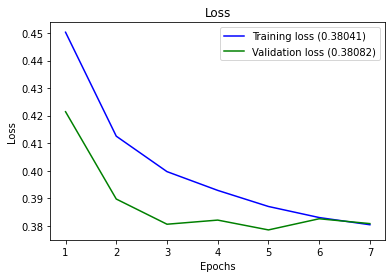

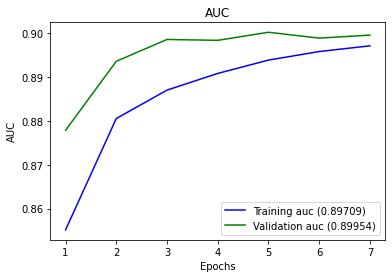

204/204 [==============================] - 1s 4ms/step
8  from  55 /  Устройство ручного ввода
Epoch 1/10
212/212 [==============================] - 4s 17ms/step - loss: 0.6045 - auc_7: 0.6685 - val_loss: 0.6164 - val_auc_7: 0.6736
Epoch 2/10
212/212 [==============================] - 3s 15ms/step - loss: 0.5934 - auc_7: 0.6998 - val_loss: 0.6016 - val_auc_7: 0.7032
Epoch 3/10
212/212 [==============================] - 3s 15ms/step - loss: 0.5747 - auc_7: 0.7244 - val_loss: 0.5869 - val_auc_7: 0.7148
Epoch 4/10
212/212 [==============================] - 3s 15ms/step - loss: 0.5548 - auc_7: 0.7529 - val_loss: 0.5768 - val_auc_7: 0.7314
Epoch 5/10
212/212 [==============================] - 3s 16ms/step - loss: 0.5297 - auc_7: 0.7796 - val_loss: 0.5446 - val_auc_7: 0.7651
Epoch 6/10
212/212 [==============================] - 3s 15ms/step - loss: 0.5002 - auc_7: 0.8065 - val_loss: 0.5247 - val_auc_7: 0.7851
Epoch 7/10
212/212 [==============================] - 3s 15ms/step - loss: 0.4817 -

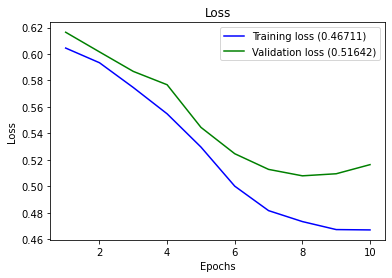

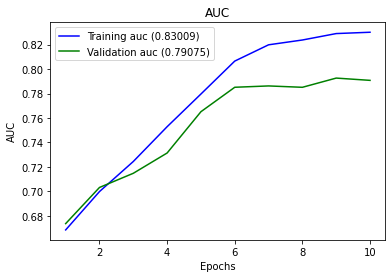

54/54 [==============================] - 0s 4ms/step
9  from  55 /  Портативная акустическая система
Epoch 1/10
53/53 [==============================] - 2s 23ms/step - loss: 0.3610 - auc_8: 0.5653 - val_loss: 0.3313 - val_auc_8: 0.6515
Epoch 2/10
53/53 [==============================] - 1s 16ms/step - loss: 0.3288 - auc_8: 0.6657 - val_loss: 0.3324 - val_auc_8: 0.6477
Epoch 3/10
53/53 [==============================] - 1s 16ms/step - loss: 0.3196 - auc_8: 0.6971 - val_loss: 0.3190 - val_auc_8: 0.6952
Epoch 4/10
53/53 [==============================] - 1s 17ms/step - loss: 0.3088 - auc_8: 0.7315 - val_loss: 0.3220 - val_auc_8: 0.7005
Epoch 5/10
53/53 [==============================] - 1s 16ms/step - loss: 0.3037 - auc_8: 0.7457 - val_loss: 0.3155 - val_auc_8: 0.7284
Epoch 6/10
53/53 [==============================] - 1s 17ms/step - loss: 0.2913 - auc_8: 0.7754 - val_loss: 0.3229 - val_auc_8: 0.7357
Epoch 7/10
53/53 [==============================] - 1s 16ms/step - loss: 0.2852 - auc_8: 

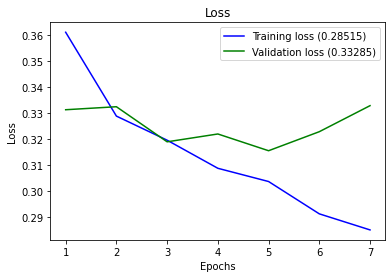

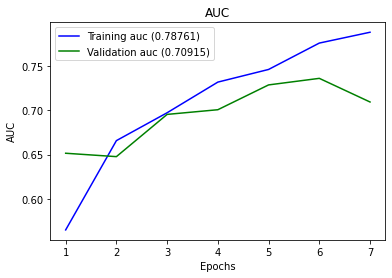

14/14 [==============================] - 0s 5ms/step
10  from  55 /  Мобильный телефон
Epoch 1/10
33/33 [==============================] - 2s 27ms/step - loss: 0.6681 - auc_9: 0.5323 - val_loss: 0.6356 - val_auc_9: 0.6026
Epoch 2/10
33/33 [==============================] - 1s 18ms/step - loss: 0.6401 - auc_9: 0.5666 - val_loss: 0.6355 - val_auc_9: 0.6164
Epoch 3/10
33/33 [==============================] - 1s 17ms/step - loss: 0.6279 - auc_9: 0.6138 - val_loss: 0.6334 - val_auc_9: 0.6487
Epoch 4/10
33/33 [==============================] - 1s 17ms/step - loss: 0.6139 - auc_9: 0.6514 - val_loss: 0.6263 - val_auc_9: 0.6891
Epoch 5/10
33/33 [==============================] - 1s 17ms/step - loss: 0.6168 - auc_9: 0.6483 - val_loss: 0.6105 - val_auc_9: 0.7156
Epoch 6/10
33/33 [==============================] - 1s 18ms/step - loss: 0.6089 - auc_9: 0.6707 - val_loss: 0.6136 - val_auc_9: 0.7245
Epoch 7/10
33/33 [==============================] - 1s 17ms/step - loss: 0.5939 - auc_9: 0.6996 - val_l

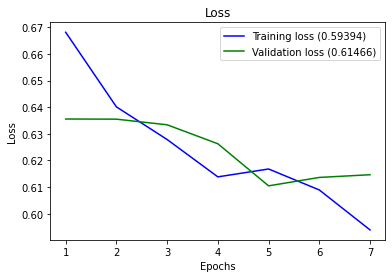

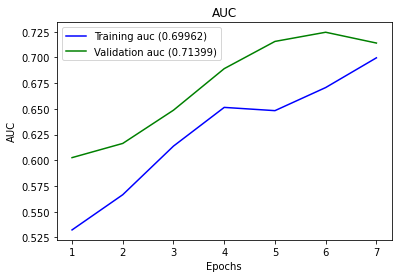

9/9 [==============================] - 0s 5ms/step
11  from  55 /  Коммутатор
Epoch 1/10
28/28 [==============================] - 2s 29ms/step - loss: 0.6467 - auc_10: 0.5642 - val_loss: 0.6492 - val_auc_10: 0.5754
Epoch 2/10
28/28 [==============================] - 0s 17ms/step - loss: 0.6219 - auc_10: 0.5951 - val_loss: 0.6219 - val_auc_10: 0.6690
Epoch 3/10
28/28 [==============================] - 1s 18ms/step - loss: 0.6055 - auc_10: 0.6267 - val_loss: 0.6154 - val_auc_10: 0.7327
Epoch 4/10
28/28 [==============================] - 0s 17ms/step - loss: 0.6152 - auc_10: 0.5989 - val_loss: 0.6216 - val_auc_10: 0.7847
Epoch 5/10
28/28 [==============================] - 0s 17ms/step - loss: 0.6166 - auc_10: 0.6138 - val_loss: 0.6081 - val_auc_10: 0.7980
Epoch 6/10
28/28 [==============================] - 0s 17ms/step - loss: 0.6089 - auc_10: 0.6455 - val_loss: 0.6103 - val_auc_10: 0.7973
Epoch 7/10
28/28 [==============================] - 0s 17ms/step - loss: 0.6043 - auc_10: 0.6483 - v

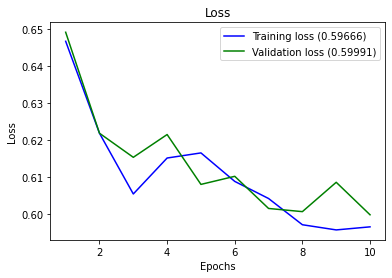

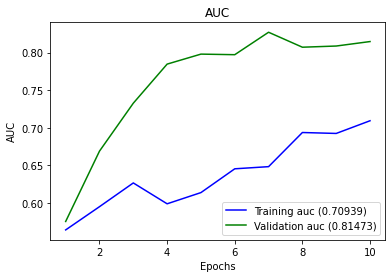

7/7 [==============================] - 0s 5ms/step
12  from  55 /  Ноутбук
Epoch 1/10
582/582 [==============================] - 10s 16ms/step - loss: 0.4074 - auc_11: 0.6494 - val_loss: 0.3662 - val_auc_11: 0.7991
Epoch 2/10
582/582 [==============================] - 9s 15ms/step - loss: 0.3592 - auc_11: 0.7815 - val_loss: 0.3557 - val_auc_11: 0.7936
Epoch 3/10
582/582 [==============================] - 9s 15ms/step - loss: 0.3550 - auc_11: 0.7870 - val_loss: 0.3544 - val_auc_11: 0.7969
Epoch 4/10
582/582 [==============================] - 9s 15ms/step - loss: 0.3506 - auc_11: 0.7914 - val_loss: 0.3545 - val_auc_11: 0.7958
Epoch 5/10
582/582 [==============================] - 9s 16ms/step - loss: 0.3501 - auc_11: 0.7904 - val_loss: 0.3448 - val_auc_11: 0.7965
Epoch 6/10
582/582 [==============================] - 9s 15ms/step - loss: 0.3480 - auc_11: 0.7938 - val_loss: 0.3463 - val_auc_11: 0.7936
Epoch 7/10
582/582 [==============================] - 9s 16ms/step - loss: 0.3475 - auc_11

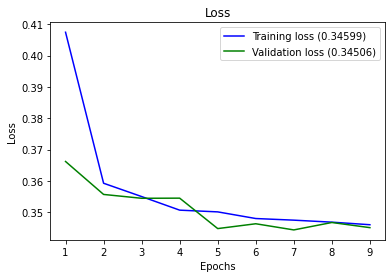

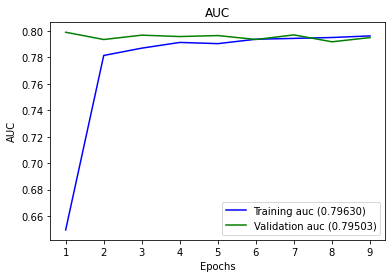

146/146 [==============================] - 1s 4ms/step
13  from  55 /  Наушники
Epoch 1/10
210/210 [==============================] - 4s 17ms/step - loss: 0.4231 - auc_12: 0.5581 - val_loss: 0.4280 - val_auc_12: 0.6287
Epoch 2/10
210/210 [==============================] - 3s 15ms/step - loss: 0.4097 - auc_12: 0.6075 - val_loss: 0.4165 - val_auc_12: 0.6642
Epoch 3/10
210/210 [==============================] - 3s 15ms/step - loss: 0.4034 - auc_12: 0.6345 - val_loss: 0.4101 - val_auc_12: 0.6831
Epoch 4/10
210/210 [==============================] - 3s 15ms/step - loss: 0.3997 - auc_12: 0.6485 - val_loss: 0.4022 - val_auc_12: 0.6863
Epoch 5/10
210/210 [==============================] - 3s 16ms/step - loss: 0.3951 - auc_12: 0.6648 - val_loss: 0.4052 - val_auc_12: 0.7045
Epoch 6/10
210/210 [==============================] - 3s 15ms/step - loss: 0.3906 - auc_12: 0.6796 - val_loss: 0.4008 - val_auc_12: 0.7136
Epoch 7/10
210/210 [==============================] - 3s 16ms/step - loss: 0.3860 - au

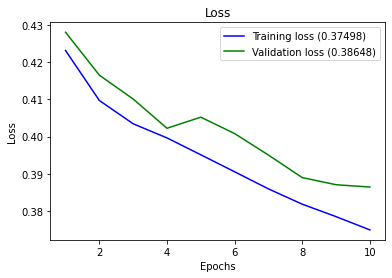

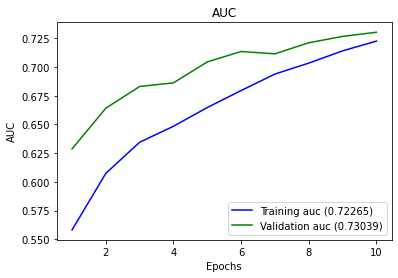

53/53 [==============================] - 0s 4ms/step
14  from  55 /  Умные часы
Epoch 1/10
251/251 [==============================] - 5s 16ms/step - loss: 0.5006 - auc_13: 0.6164 - val_loss: 0.4864 - val_auc_13: 0.6533
Epoch 2/10
251/251 [==============================] - 4s 15ms/step - loss: 0.4833 - auc_13: 0.6613 - val_loss: 0.4816 - val_auc_13: 0.6689
Epoch 3/10
251/251 [==============================] - 4s 15ms/step - loss: 0.4785 - auc_13: 0.6689 - val_loss: 0.4827 - val_auc_13: 0.6527
Epoch 4/10
251/251 [==============================] - 4s 15ms/step - loss: 0.4730 - auc_13: 0.6807 - val_loss: 0.4765 - val_auc_13: 0.6769
Epoch 5/10
251/251 [==============================] - 4s 15ms/step - loss: 0.4682 - auc_13: 0.6870 - val_loss: 0.4768 - val_auc_13: 0.6737
Epoch 6/10
251/251 [==============================] - 4s 15ms/step - loss: 0.4655 - auc_13: 0.6902 - val_loss: 0.4664 - val_auc_13: 0.6979
Epoch 7/10
251/251 [==============================] - 4s 15ms/step - loss: 0.4595 - au

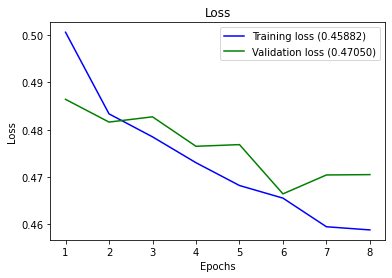

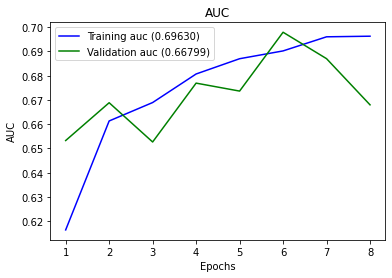

63/63 [==============================] - 0s 4ms/step
15  from  55 /  Батарейки и аккумуляторы
Epoch 1/10
191/191 [==============================] - 4s 17ms/step - loss: 0.5630 - auc_14: 0.7791 - val_loss: 0.5348 - val_auc_14: 0.8098
Epoch 2/10
191/191 [==============================] - 3s 16ms/step - loss: 0.5283 - auc_14: 0.8068 - val_loss: 0.5113 - val_auc_14: 0.8201
Epoch 3/10
191/191 [==============================] - 3s 16ms/step - loss: 0.5055 - auc_14: 0.8249 - val_loss: 0.4962 - val_auc_14: 0.8386
Epoch 4/10
191/191 [==============================] - 3s 16ms/step - loss: 0.4812 - auc_14: 0.8440 - val_loss: 0.4922 - val_auc_14: 0.8339
Epoch 5/10
191/191 [==============================] - 3s 16ms/step - loss: 0.4650 - auc_14: 0.8536 - val_loss: 0.4809 - val_auc_14: 0.8392
Epoch 6/10
191/191 [==============================] - 3s 16ms/step - loss: 0.4531 - auc_14: 0.8622 - val_loss: 0.4766 - val_auc_14: 0.8481
Epoch 7/10
191/191 [==============================] - 3s 16ms/step - los

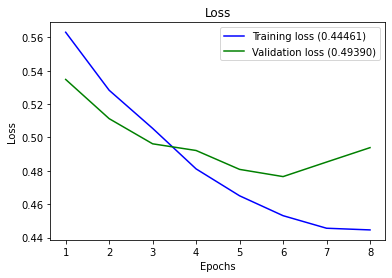

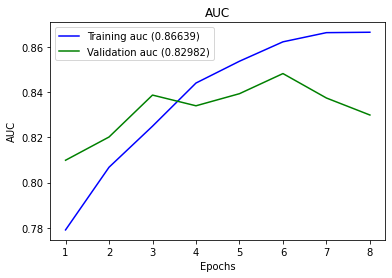

48/48 [==============================] - 0s 4ms/step
16  from  55 /  Телевизор
Epoch 1/10
85/85 [==============================] - 3s 20ms/step - loss: 0.6767 - auc_15: 0.5392 - val_loss: 0.6453 - val_auc_15: 0.6749
Epoch 2/10
85/85 [==============================] - 1s 16ms/step - loss: 0.6441 - auc_15: 0.6295 - val_loss: 0.6281 - val_auc_15: 0.7219
Epoch 3/10
85/85 [==============================] - 1s 16ms/step - loss: 0.6225 - auc_15: 0.6894 - val_loss: 0.6044 - val_auc_15: 0.7751
Epoch 4/10
85/85 [==============================] - 1s 16ms/step - loss: 0.5902 - auc_15: 0.7575 - val_loss: 0.5656 - val_auc_15: 0.8018
Epoch 5/10
85/85 [==============================] - 1s 16ms/step - loss: 0.5517 - auc_15: 0.7953 - val_loss: 0.5420 - val_auc_15: 0.8129
Epoch 6/10
85/85 [==============================] - 1s 15ms/step - loss: 0.5295 - auc_15: 0.8033 - val_loss: 0.5177 - val_auc_15: 0.8163
Epoch 7/10
85/85 [==============================] - 1s 16ms/step - loss: 0.5085 - auc_15: 0.8121 - 

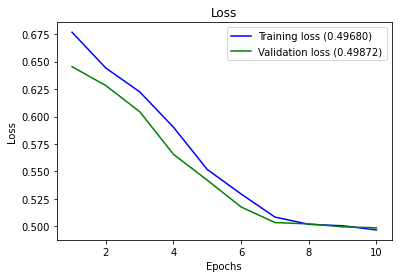

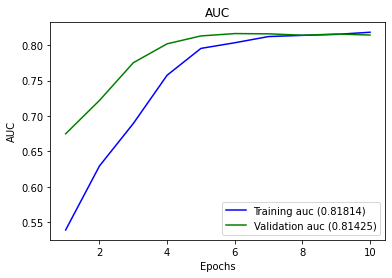

22/22 [==============================] - 0s 5ms/step
17  from  55 /  Умный дом
Epoch 1/10
26/26 [==============================] - 2s 29ms/step - loss: 0.5663 - auc_16: 0.7750 - val_loss: 0.5481 - val_auc_16: 0.8153
Epoch 2/10
26/26 [==============================] - 0s 17ms/step - loss: 0.4800 - auc_16: 0.8505 - val_loss: 0.5071 - val_auc_16: 0.8336
Epoch 3/10
26/26 [==============================] - 0s 17ms/step - loss: 0.4496 - auc_16: 0.8669 - val_loss: 0.4996 - val_auc_16: 0.8461
Epoch 4/10
26/26 [==============================] - 0s 18ms/step - loss: 0.4089 - auc_16: 0.8920 - val_loss: 0.4907 - val_auc_16: 0.8487
Epoch 5/10
26/26 [==============================] - 0s 18ms/step - loss: 0.3985 - auc_16: 0.8976 - val_loss: 0.4759 - val_auc_16: 0.8576
Epoch 6/10
26/26 [==============================] - 0s 18ms/step - loss: 0.3591 - auc_16: 0.9154 - val_loss: 0.5073 - val_auc_16: 0.8454
Epoch 7/10
26/26 [==============================] - 0s 18ms/step - loss: 0.3516 - auc_16: 0.9194 - 

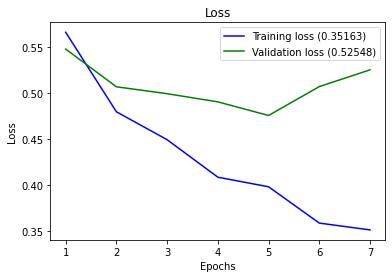

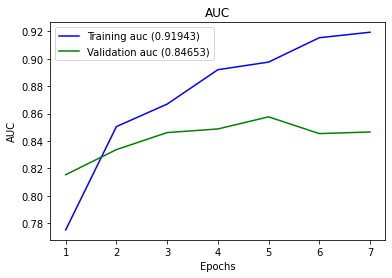

7/7 [==============================] - 0s 5ms/step
18  from  55 /  Видеокарта
Epoch 1/10
70/70 [==============================] - 2s 21ms/step - loss: 0.6772 - auc_17: 0.5316 - val_loss: 0.6797 - val_auc_17: 0.5554
Epoch 2/10
70/70 [==============================] - 1s 16ms/step - loss: 0.6718 - auc_17: 0.5354 - val_loss: 0.6849 - val_auc_17: 0.5652
Epoch 3/10
70/70 [==============================] - 1s 17ms/step - loss: 0.6720 - auc_17: 0.5251 - val_loss: 0.6688 - val_auc_17: 0.5000
Epoch 4/10
70/70 [==============================] - 1s 21ms/step - loss: 0.6695 - auc_17: 0.5286 - val_loss: 0.6689 - val_auc_17: 0.5000
Epoch 5/10
70/70 [==============================] - 1s 18ms/step - loss: 0.6702 - auc_17: 0.4688 - val_loss: 0.6688 - val_auc_17: 0.4992
Epoch 6/10
70/70 [==============================] - 1s 18ms/step - loss: 0.6700 - auc_17: 0.4685 - val_loss: 0.6687 - val_auc_17: 0.4990
Epoch 7/10
70/70 [==============================] - 1s 18ms/step - loss: 0.6700 - auc_17: 0.4731 - v

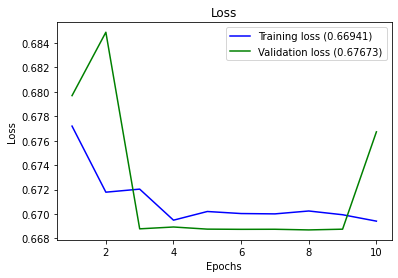

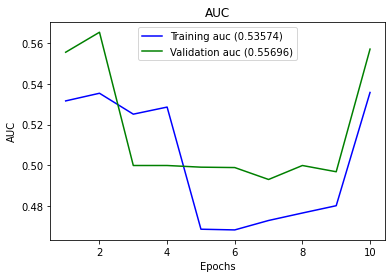

18/18 [==============================] - 0s 5ms/step
19  from  55 /  Коврик для мыши
Epoch 1/10
33/33 [==============================] - 2s 29ms/step - loss: 0.5881 - auc_18: 0.7470 - val_loss: 0.5491 - val_auc_18: 0.8510
Epoch 2/10
33/33 [==============================] - 1s 19ms/step - loss: 0.4967 - auc_18: 0.8314 - val_loss: 0.4463 - val_auc_18: 0.8710
Epoch 3/10
33/33 [==============================] - 1s 17ms/step - loss: 0.4226 - auc_18: 0.8811 - val_loss: 0.4438 - val_auc_18: 0.8890
Epoch 4/10
33/33 [==============================] - 1s 18ms/step - loss: 0.4026 - auc_18: 0.8909 - val_loss: 0.4416 - val_auc_18: 0.8901
Epoch 5/10
33/33 [==============================] - 1s 19ms/step - loss: 0.3780 - auc_18: 0.9026 - val_loss: 0.4517 - val_auc_18: 0.8803
Epoch 6/10
33/33 [==============================] - 1s 17ms/step - loss: 0.3561 - auc_18: 0.9141 - val_loss: 0.4776 - val_auc_18: 0.8741


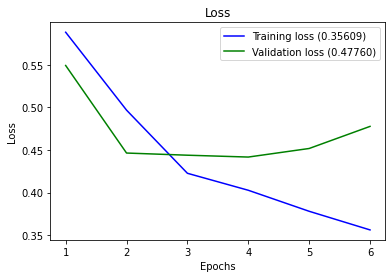

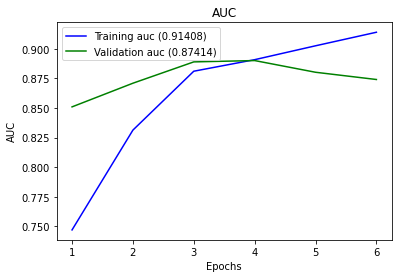

9/9 [==============================] - 0s 5ms/step
20  from  55 /  Модуль оперативной памяти
Epoch 1/10
64/64 [==============================] - 2s 23ms/step - loss: 0.5057 - auc_19: 0.5448 - val_loss: 0.4838 - val_auc_19: 0.6029
Epoch 2/10
64/64 [==============================] - 1s 16ms/step - loss: 0.4754 - auc_19: 0.6393 - val_loss: 0.5115 - val_auc_19: 0.5545
Epoch 3/10
64/64 [==============================] - 1s 16ms/step - loss: 0.4667 - auc_19: 0.6649 - val_loss: 0.4966 - val_auc_19: 0.5801


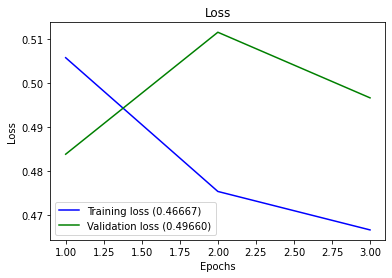

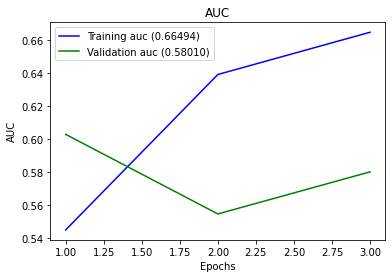

17/17 [==============================] - 0s 4ms/step
21  from  55 /  Чехол
Epoch 1/10
579/579 [==============================] - 10s 15ms/step - loss: 0.4911 - auc_20: 0.7212 - val_loss: 0.4918 - val_auc_20: 0.7433
Epoch 2/10
579/579 [==============================] - 9s 15ms/step - loss: 0.4714 - auc_20: 0.7557 - val_loss: 0.4808 - val_auc_20: 0.7584
Epoch 3/10
579/579 [==============================] - 9s 16ms/step - loss: 0.4620 - auc_20: 0.7693 - val_loss: 0.4762 - val_auc_20: 0.7602
Epoch 4/10
579/579 [==============================] - 9s 16ms/step - loss: 0.4584 - auc_20: 0.7743 - val_loss: 0.4755 - val_auc_20: 0.7641
Epoch 5/10
579/579 [==============================] - 9s 16ms/step - loss: 0.4551 - auc_20: 0.7783 - val_loss: 0.4749 - val_auc_20: 0.7650
Epoch 6/10
579/579 [==============================] - 9s 15ms/step - loss: 0.4523 - auc_20: 0.7814 - val_loss: 0.4729 - val_auc_20: 0.7649
Epoch 7/10
579/579 [==============================] - 9s 15ms/step - loss: 0.4507 - auc_20

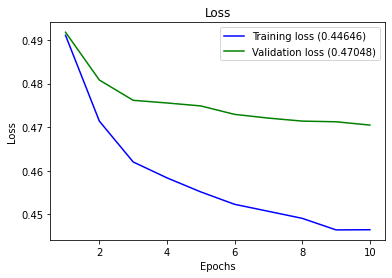

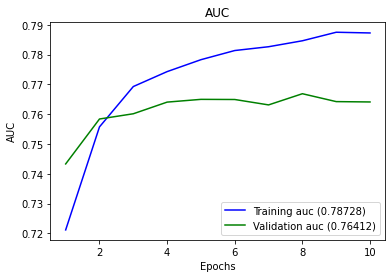

145/145 [==============================] - 1s 4ms/step
22  from  55 /  Кабель
Epoch 1/10
445/445 [==============================] - 8s 16ms/step - loss: 0.4830 - auc_21: 0.7819 - val_loss: 0.4911 - val_auc_21: 0.8168
Epoch 2/10
445/445 [==============================] - 7s 15ms/step - loss: 0.4480 - auc_21: 0.8179 - val_loss: 0.4580 - val_auc_21: 0.8398
Epoch 3/10
445/445 [==============================] - 7s 15ms/step - loss: 0.4264 - auc_21: 0.8403 - val_loss: 0.4311 - val_auc_21: 0.8543
Epoch 4/10
445/445 [==============================] - 7s 15ms/step - loss: 0.4064 - auc_21: 0.8563 - val_loss: 0.4117 - val_auc_21: 0.8602
Epoch 5/10
445/445 [==============================] - 7s 16ms/step - loss: 0.3961 - auc_21: 0.8632 - val_loss: 0.4041 - val_auc_21: 0.8599
Epoch 6/10
445/445 [==============================] - 7s 15ms/step - loss: 0.3874 - auc_21: 0.8698 - val_loss: 0.4022 - val_auc_21: 0.8623
Epoch 7/10
445/445 [==============================] - 7s 15ms/step - loss: 0.3824 - auc_

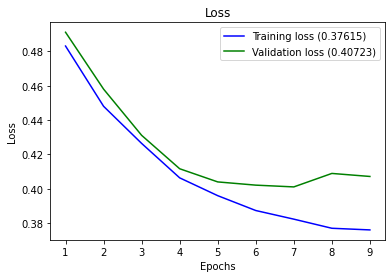

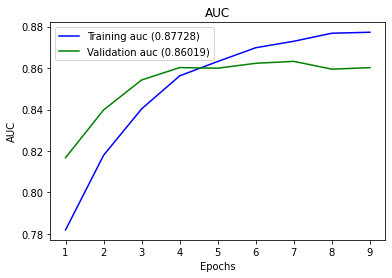

112/112 [==============================] - 1s 4ms/step
23  from  55 /  Матрица для ноутбука
Epoch 1/10
36/36 [==============================] - 2s 27ms/step - loss: 0.5153 - auc_22: 0.5675 - val_loss: 0.4721 - val_auc_22: 0.6485
Epoch 2/10
36/36 [==============================] - 1s 18ms/step - loss: 0.4738 - auc_22: 0.6565 - val_loss: 0.4701 - val_auc_22: 0.6529
Epoch 3/10
36/36 [==============================] - 1s 17ms/step - loss: 0.4661 - auc_22: 0.6711 - val_loss: 0.4730 - val_auc_22: 0.6403
Epoch 4/10
36/36 [==============================] - 1s 17ms/step - loss: 0.4628 - auc_22: 0.6795 - val_loss: 0.4716 - val_auc_22: 0.6424


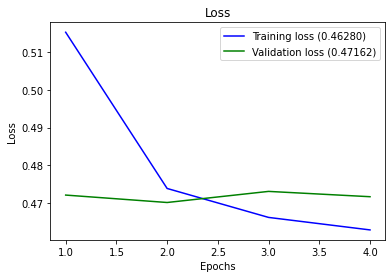

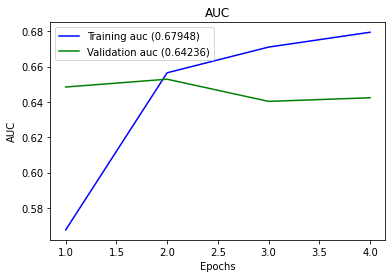

10/10 [==============================] - 0s 5ms/step
24  from  55 /  Картридж
Epoch 1/10
539/539 [==============================] - 10s 18ms/step - loss: 0.6481 - auc_23: 0.6625 - val_loss: 0.5742 - val_auc_23: 0.7892
Epoch 2/10
539/539 [==============================] - 9s 16ms/step - loss: 0.5274 - auc_23: 0.8233 - val_loss: 0.4985 - val_auc_23: 0.8417
Epoch 3/10
539/539 [==============================] - 9s 16ms/step - loss: 0.4903 - auc_23: 0.8433 - val_loss: 0.4849 - val_auc_23: 0.8451
Epoch 4/10
539/539 [==============================] - 9s 16ms/step - loss: 0.4787 - auc_23: 0.8493 - val_loss: 0.4788 - val_auc_23: 0.8471
Epoch 5/10
539/539 [==============================] - 8s 16ms/step - loss: 0.4722 - auc_23: 0.8530 - val_loss: 0.4725 - val_auc_23: 0.8521
Epoch 6/10
539/539 [==============================] - 8s 16ms/step - loss: 0.4696 - auc_23: 0.8536 - val_loss: 0.4713 - val_auc_23: 0.8521
Epoch 7/10
539/539 [==============================] - 9s 16ms/step - loss: 0.4669 - auc

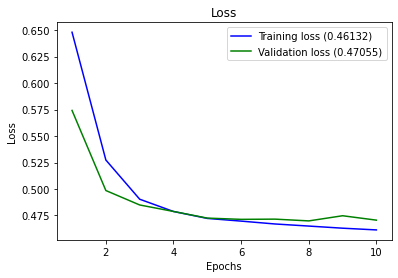

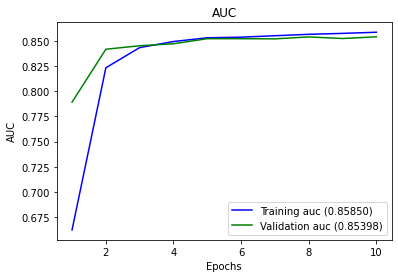

135/135 [==============================] - 1s 4ms/step
25  from  55 /  Проводные и DECT-телефоны
Epoch 1/10
21/21 [==============================] - 2s 34ms/step - loss: 0.5052 - auc_24: 0.6566 - val_loss: 0.4865 - val_auc_24: 0.7069
Epoch 2/10
21/21 [==============================] - 0s 17ms/step - loss: 0.4602 - auc_24: 0.7316 - val_loss: 0.4919 - val_auc_24: 0.7234
Epoch 3/10
21/21 [==============================] - 0s 17ms/step - loss: 0.4481 - auc_24: 0.7500 - val_loss: 0.4848 - val_auc_24: 0.7345
Epoch 4/10
21/21 [==============================] - 0s 18ms/step - loss: 0.4337 - auc_24: 0.7627 - val_loss: 0.4653 - val_auc_24: 0.7447
Epoch 5/10
21/21 [==============================] - 0s 17ms/step - loss: 0.4218 - auc_24: 0.7759 - val_loss: 0.4549 - val_auc_24: 0.7564
Epoch 6/10
21/21 [==============================] - 0s 17ms/step - loss: 0.4125 - auc_24: 0.7904 - val_loss: 0.4464 - val_auc_24: 0.7736
Epoch 7/10
21/21 [==============================] - 0s 19ms/step - loss: 0.4001 -

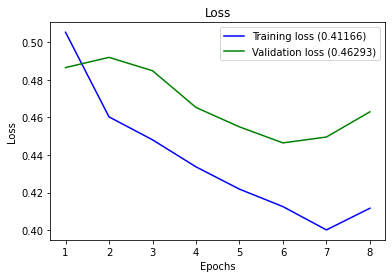

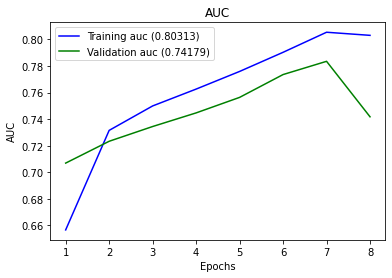

6/6 [==============================] - 0s 4ms/step
26  from  55 /  Клавиатура для ноутбука
Epoch 1/10
77/77 [==============================] - 3s 20ms/step - loss: 0.6386 - auc_25: 0.5780 - val_loss: 0.6222 - val_auc_25: 0.6415
Epoch 2/10
77/77 [==============================] - 1s 15ms/step - loss: 0.6146 - auc_25: 0.6479 - val_loss: 0.6187 - val_auc_25: 0.6556
Epoch 3/10
77/77 [==============================] - 1s 15ms/step - loss: 0.6046 - auc_25: 0.6690 - val_loss: 0.6123 - val_auc_25: 0.6686
Epoch 4/10
77/77 [==============================] - 1s 16ms/step - loss: 0.5951 - auc_25: 0.6864 - val_loss: 0.6033 - val_auc_25: 0.6770
Epoch 5/10
77/77 [==============================] - 1s 16ms/step - loss: 0.5898 - auc_25: 0.6975 - val_loss: 0.5969 - val_auc_25: 0.6890
Epoch 6/10
77/77 [==============================] - 1s 15ms/step - loss: 0.5741 - auc_25: 0.7218 - val_loss: 0.5995 - val_auc_25: 0.6939
Epoch 7/10
77/77 [==============================] - 1s 16ms/step - loss: 0.5669 - auc_2

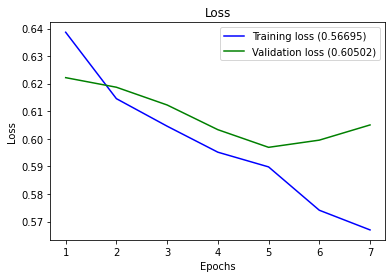

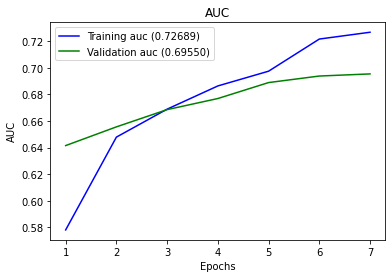

20/20 [==============================] - 0s 5ms/step
27  from  55 /  Моноблок
Epoch 1/10
89/89 [==============================] - 3s 19ms/step - loss: 0.3084 - auc_26: 0.5771 - val_loss: 0.2855 - val_auc_26: 0.6819
Epoch 2/10
89/89 [==============================] - 1s 15ms/step - loss: 0.2933 - auc_26: 0.6332 - val_loss: 0.2774 - val_auc_26: 0.7101
Epoch 3/10
89/89 [==============================] - 1s 16ms/step - loss: 0.2860 - auc_26: 0.6679 - val_loss: 0.2723 - val_auc_26: 0.7166
Epoch 4/10
89/89 [==============================] - 1s 15ms/step - loss: 0.2799 - auc_26: 0.6945 - val_loss: 0.2680 - val_auc_26: 0.7341
Epoch 5/10
89/89 [==============================] - 1s 14ms/step - loss: 0.2773 - auc_26: 0.7010 - val_loss: 0.2675 - val_auc_26: 0.7338
Epoch 6/10
89/89 [==============================] - 1s 15ms/step - loss: 0.2761 - auc_26: 0.7058 - val_loss: 0.2700 - val_auc_26: 0.7241
Epoch 7/10
89/89 [==============================] - 1s 16ms/step - loss: 0.2739 - auc_26: 0.7114 - v

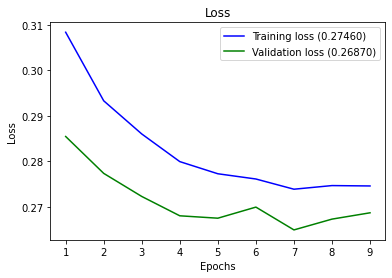

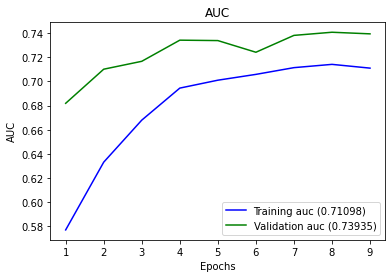

23/23 [==============================] - 0s 4ms/step
28  from  55 /  Электронные модули
Epoch 1/10
85/85 [==============================] - 3s 21ms/step - loss: 0.4560 - auc_27: 0.6689 - val_loss: 0.4181 - val_auc_27: 0.7454
Epoch 2/10
85/85 [==============================] - 1s 16ms/step - loss: 0.4148 - auc_27: 0.7418 - val_loss: 0.4105 - val_auc_27: 0.7572
Epoch 3/10
85/85 [==============================] - 1s 16ms/step - loss: 0.4053 - auc_27: 0.7573 - val_loss: 0.4077 - val_auc_27: 0.7627
Epoch 4/10
85/85 [==============================] - 1s 16ms/step - loss: 0.3951 - auc_27: 0.7733 - val_loss: 0.4050 - val_auc_27: 0.7660
Epoch 5/10
85/85 [==============================] - 1s 16ms/step - loss: 0.3873 - auc_27: 0.7859 - val_loss: 0.4042 - val_auc_27: 0.7700
Epoch 6/10
85/85 [==============================] - 1s 18ms/step - loss: 0.3802 - auc_27: 0.7962 - val_loss: 0.4076 - val_auc_27: 0.7661
Epoch 7/10
85/85 [==============================] - 1s 18ms/step - loss: 0.3720 - auc_27: 

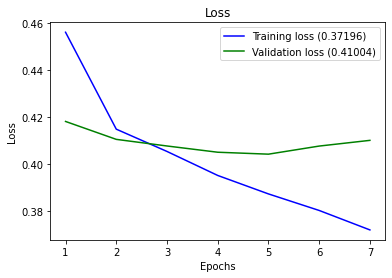

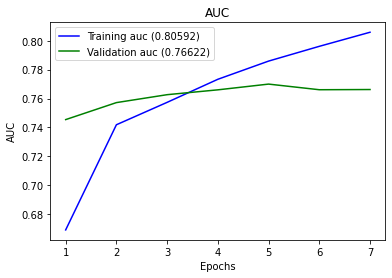

22/22 [==============================] - 0s 4ms/step
29  from  55 /  Видеодомофон
Epoch 1/10
20/20 [==============================] - 2s 44ms/step - loss: 0.6212 - auc_28: 0.5163 - val_loss: 0.5917 - val_auc_28: 0.5879
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5904 - auc_28: 0.6179 - val_loss: 0.5880 - val_auc_28: 0.6063
Epoch 3/10
20/20 [==============================] - 1s 26ms/step - loss: 0.5803 - auc_28: 0.6520 - val_loss: 0.5758 - val_auc_28: 0.6467
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5661 - auc_28: 0.6922 - val_loss: 0.5590 - val_auc_28: 0.7108
Epoch 5/10
20/20 [==============================] - 0s 19ms/step - loss: 0.5630 - auc_28: 0.6865 - val_loss: 0.5634 - val_auc_28: 0.6928
Epoch 6/10
20/20 [==============================] - 0s 20ms/step - loss: 0.5603 - auc_28: 0.6871 - val_loss: 0.5599 - val_auc_28: 0.6820


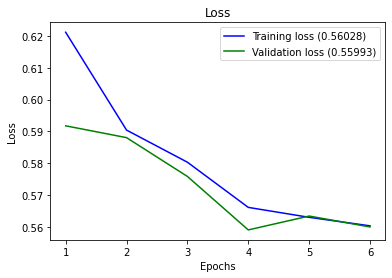

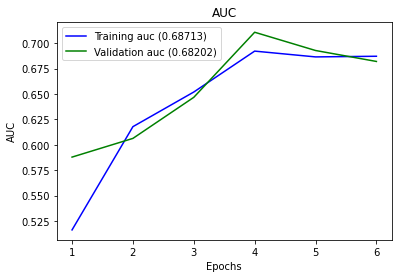

6/6 [==============================] - 0s 5ms/step
30  from  55 /  Планшет
Epoch 1/10
97/97 [==============================] - 3s 21ms/step - loss: 0.5488 - auc_29: 0.6830 - val_loss: 0.5280 - val_auc_29: 0.7211
Epoch 2/10
97/97 [==============================] - 2s 16ms/step - loss: 0.5188 - auc_29: 0.7361 - val_loss: 0.5403 - val_auc_29: 0.7276
Epoch 3/10
97/97 [==============================] - 2s 17ms/step - loss: 0.5170 - auc_29: 0.7397 - val_loss: 0.5503 - val_auc_29: 0.7326


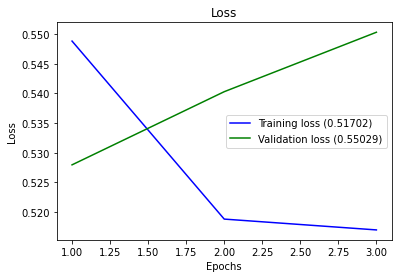

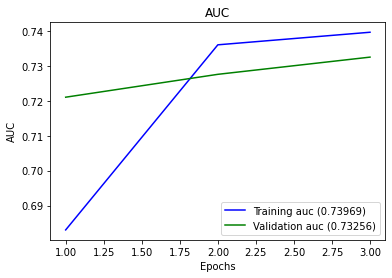

25/25 [==============================] - 0s 5ms/step
31  from  55 /  Игровая приставка
Epoch 1/10
346/346 [==============================] - 6s 16ms/step - loss: 0.1476 - auc_30: 0.5780 - val_loss: 0.1346 - val_auc_30: 0.6937
Epoch 2/10
346/346 [==============================] - 5s 15ms/step - loss: 0.1396 - auc_30: 0.6286 - val_loss: 0.1323 - val_auc_30: 0.7039
Epoch 3/10
346/346 [==============================] - 5s 14ms/step - loss: 0.1378 - auc_30: 0.6361 - val_loss: 0.1322 - val_auc_30: 0.6894
Epoch 4/10
346/346 [==============================] - 5s 15ms/step - loss: 0.1369 - auc_30: 0.6447 - val_loss: 0.1324 - val_auc_30: 0.6937
Epoch 5/10
346/346 [==============================] - 5s 14ms/step - loss: 0.1357 - auc_30: 0.6569 - val_loss: 0.1310 - val_auc_30: 0.7058
Epoch 6/10
346/346 [==============================] - 5s 15ms/step - loss: 0.1355 - auc_30: 0.6519 - val_loss: 0.1327 - val_auc_30: 0.6958
Epoch 7/10
346/346 [==============================] - 5s 14ms/step - loss: 0.13

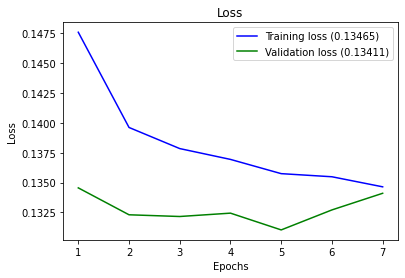

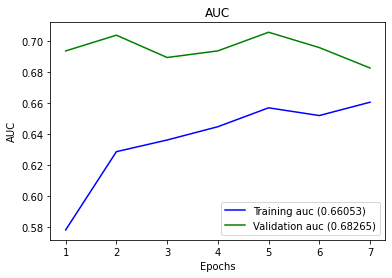

87/87 [==============================] - 0s 4ms/step
32  from  55 /  Конфигуратор ПК
Epoch 1/10
35/35 [==============================] - 2s 24ms/step - loss: 0.2845 - auc_31: 0.5060 - val_loss: 0.2169 - val_auc_31: 0.5841
Epoch 2/10
35/35 [==============================] - 1s 15ms/step - loss: 0.2227 - auc_31: 0.4770 - val_loss: 0.2179 - val_auc_31: 0.5511
Epoch 3/10
35/35 [==============================] - 1s 16ms/step - loss: 0.2220 - auc_31: 0.4915 - val_loss: 0.2183 - val_auc_31: 0.5405


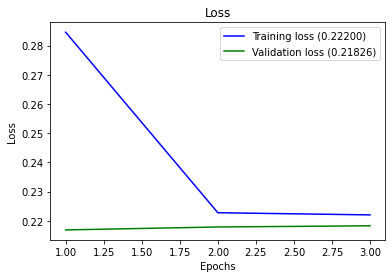

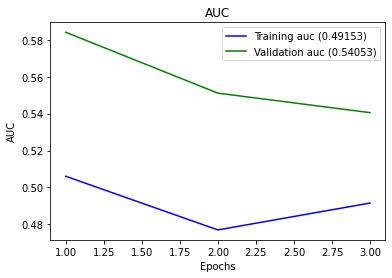

9/9 [==============================] - 0s 4ms/step
33  from  55 /  Видеонаблюдение
Epoch 1/10
155/155 [==============================] - 4s 17ms/step - loss: 0.6584 - auc_32: 0.5081 - val_loss: 0.6415 - val_auc_32: 0.6105
Epoch 2/10
155/155 [==============================] - 2s 15ms/step - loss: 0.6422 - auc_32: 0.5743 - val_loss: 0.6313 - val_auc_32: 0.6230
Epoch 3/10
155/155 [==============================] - 2s 15ms/step - loss: 0.6315 - auc_32: 0.6074 - val_loss: 0.6323 - val_auc_32: 0.6113
Epoch 4/10
155/155 [==============================] - 2s 15ms/step - loss: 0.6235 - auc_32: 0.6309 - val_loss: 0.6259 - val_auc_32: 0.6333
Epoch 5/10
155/155 [==============================] - 2s 15ms/step - loss: 0.6180 - auc_32: 0.6554 - val_loss: 0.6197 - val_auc_32: 0.6422
Epoch 6/10
155/155 [==============================] - 2s 15ms/step - loss: 0.6080 - auc_32: 0.6656 - val_loss: 0.6181 - val_auc_32: 0.6510
Epoch 7/10
155/155 [==============================] - 2s 16ms/step - loss: 0.5999 -

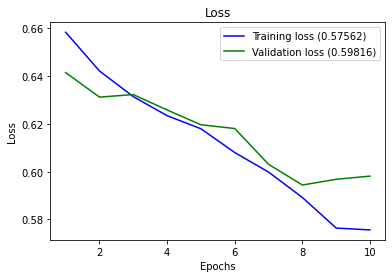

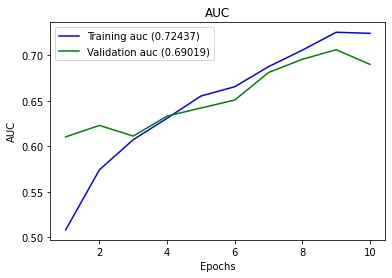

39/39 [==============================] - 0s 4ms/step
34  from  55 /  Телескоп
Epoch 1/10
53/53 [==============================] - 2s 21ms/step - loss: 0.6075 - auc_33: 0.6635 - val_loss: 0.5981 - val_auc_33: 0.7304
Epoch 2/10
53/53 [==============================] - 1s 15ms/step - loss: 0.5455 - auc_33: 0.7668 - val_loss: 0.5846 - val_auc_33: 0.7325
Epoch 3/10
53/53 [==============================] - 1s 16ms/step - loss: 0.5180 - auc_33: 0.7978 - val_loss: 0.5918 - val_auc_33: 0.7412
Epoch 4/10
53/53 [==============================] - 1s 15ms/step - loss: 0.5099 - auc_33: 0.8070 - val_loss: 0.5668 - val_auc_33: 0.7743
Epoch 5/10
53/53 [==============================] - 1s 15ms/step - loss: 0.4932 - auc_33: 0.8194 - val_loss: 0.5659 - val_auc_33: 0.7756
Epoch 6/10
53/53 [==============================] - 1s 15ms/step - loss: 0.4861 - auc_33: 0.8265 - val_loss: 0.5445 - val_auc_33: 0.7878
Epoch 7/10
53/53 [==============================] - 1s 16ms/step - loss: 0.4693 - auc_33: 0.8383 - v

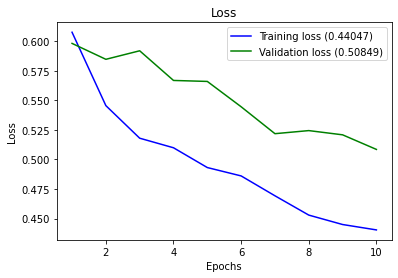

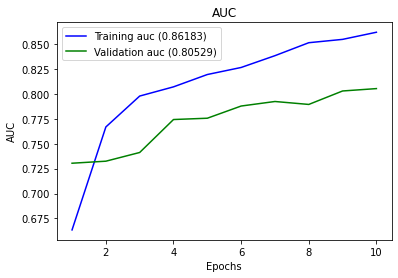

14/14 [==============================] - 0s 4ms/step
35  from  55 /  Маршрутизатор
Epoch 1/10
30/30 [==============================] - 2s 26ms/step - loss: 0.5364 - auc_34: 0.5346 - val_loss: 0.5387 - val_auc_34: 0.5004
Epoch 2/10
30/30 [==============================] - 0s 16ms/step - loss: 0.5007 - auc_34: 0.5449 - val_loss: 0.4926 - val_auc_34: 0.5589
Epoch 3/10
30/30 [==============================] - 0s 16ms/step - loss: 0.4763 - auc_34: 0.6266 - val_loss: 0.4954 - val_auc_34: 0.5572
Epoch 4/10
30/30 [==============================] - 0s 15ms/step - loss: 0.4712 - auc_34: 0.6456 - val_loss: 0.5027 - val_auc_34: 0.5464


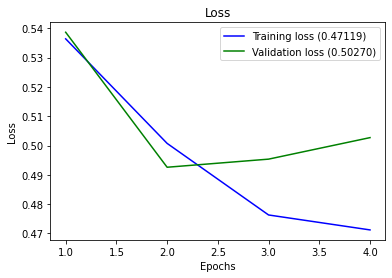

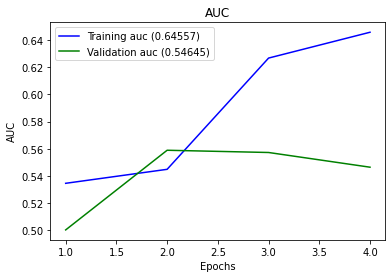

8/8 [==============================] - 0s 4ms/step
36  from  55 /  Стяжка для кабеля
Epoch 1/10
43/43 [==============================] - 2s 22ms/step - loss: 0.3552 - auc_35: 0.6125 - val_loss: 0.3934 - val_auc_35: 0.7407
Epoch 2/10
43/43 [==============================] - 1s 15ms/step - loss: 0.3129 - auc_35: 0.6858 - val_loss: 0.3619 - val_auc_35: 0.7646
Epoch 3/10
43/43 [==============================] - 1s 15ms/step - loss: 0.3023 - auc_35: 0.6972 - val_loss: 0.3538 - val_auc_35: 0.7434
Epoch 4/10
43/43 [==============================] - 1s 15ms/step - loss: 0.2958 - auc_35: 0.7052 - val_loss: 0.3622 - val_auc_35: 0.7360
Epoch 5/10
43/43 [==============================] - 1s 15ms/step - loss: 0.2894 - auc_35: 0.7098 - val_loss: 0.3572 - val_auc_35: 0.7423


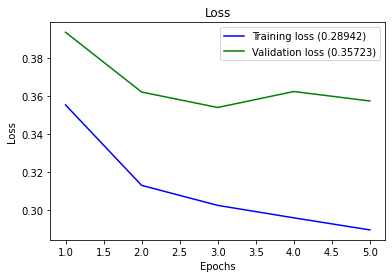

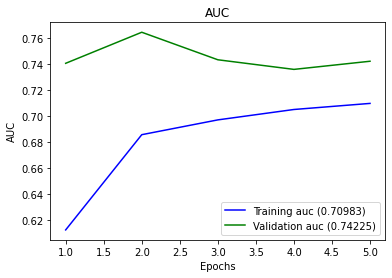

11/11 [==============================] - 0s 4ms/step
37  from  55 /  Сетевой фильтр, удлинитель, разветвитель
Epoch 1/10
57/57 [==============================] - 2s 21ms/step - loss: 0.6378 - auc_36: 0.6424 - val_loss: 0.5941 - val_auc_36: 0.7186
Epoch 2/10
57/57 [==============================] - 1s 15ms/step - loss: 0.5912 - auc_36: 0.7217 - val_loss: 0.5775 - val_auc_36: 0.7492
Epoch 3/10
57/57 [==============================] - 1s 15ms/step - loss: 0.5726 - auc_36: 0.7439 - val_loss: 0.5559 - val_auc_36: 0.7730
Epoch 4/10
57/57 [==============================] - 1s 15ms/step - loss: 0.5545 - auc_36: 0.7602 - val_loss: 0.5432 - val_auc_36: 0.7850
Epoch 5/10
57/57 [==============================] - 1s 15ms/step - loss: 0.5352 - auc_36: 0.7887 - val_loss: 0.5105 - val_auc_36: 0.8225
Epoch 6/10
57/57 [==============================] - 1s 15ms/step - loss: 0.5156 - auc_36: 0.8121 - val_loss: 0.5035 - val_auc_36: 0.8251
Epoch 7/10
57/57 [==============================] - 1s 15ms/step - l

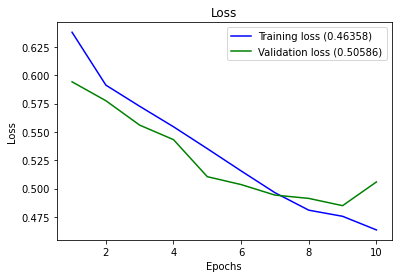

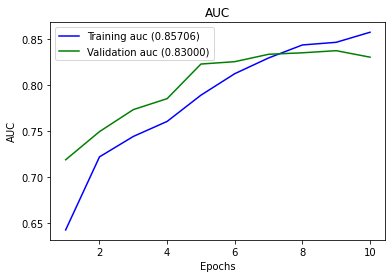

15/15 [==============================] - 0s 4ms/step
38  from  55 /  Материнская плата
Epoch 1/10
167/167 [==============================] - 4s 16ms/step - loss: 0.5975 - auc_37: 0.6607 - val_loss: 0.5875 - val_auc_37: 0.6629
Epoch 2/10
167/167 [==============================] - 2s 14ms/step - loss: 0.5758 - auc_37: 0.6759 - val_loss: 0.5695 - val_auc_37: 0.6890
Epoch 3/10
167/167 [==============================] - 2s 14ms/step - loss: 0.5704 - auc_37: 0.6816 - val_loss: 0.5692 - val_auc_37: 0.6861
Epoch 4/10
167/167 [==============================] - 2s 14ms/step - loss: 0.5659 - auc_37: 0.6864 - val_loss: 0.5670 - val_auc_37: 0.6904
Epoch 5/10
167/167 [==============================] - 2s 14ms/step - loss: 0.5654 - auc_37: 0.6863 - val_loss: 0.5671 - val_auc_37: 0.6904
Epoch 6/10
167/167 [==============================] - 2s 14ms/step - loss: 0.5621 - auc_37: 0.6866 - val_loss: 0.5638 - val_auc_37: 0.6936
Epoch 7/10
167/167 [==============================] - 3s 15ms/step - loss: 0.55

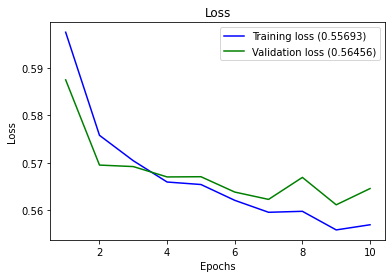

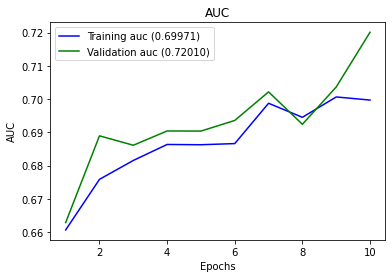

42/42 [==============================] - 0s 4ms/step
39  from  55 /  Термопленка
Epoch 1/10
20/20 [==============================] - 1s 35ms/step - loss: 0.5679 - auc_38: 0.6043 - val_loss: 0.5814 - val_auc_38: 0.5965
Epoch 2/10
20/20 [==============================] - 0s 17ms/step - loss: 0.5332 - auc_38: 0.6830 - val_loss: 0.5819 - val_auc_38: 0.6398
Epoch 3/10
20/20 [==============================] - 0s 18ms/step - loss: 0.5151 - auc_38: 0.7149 - val_loss: 0.5706 - val_auc_38: 0.6547
Epoch 4/10
20/20 [==============================] - 0s 17ms/step - loss: 0.4966 - auc_38: 0.7452 - val_loss: 0.5804 - val_auc_38: 0.6607
Epoch 5/10
20/20 [==============================] - 0s 17ms/step - loss: 0.4871 - auc_38: 0.7562 - val_loss: 0.6102 - val_auc_38: 0.6381


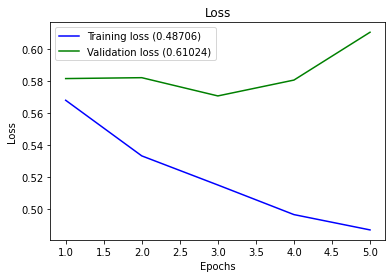

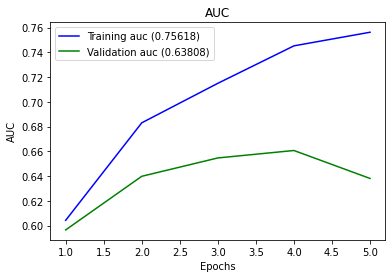

6/6 [==============================] - 0s 4ms/step
40  from  55 /  Запчасти для смартфонов
Epoch 1/10
150/150 [==============================] - 3s 17ms/step - loss: 0.6678 - auc_39: 0.5802 - val_loss: 0.6491 - val_auc_39: 0.6341
Epoch 2/10
150/150 [==============================] - 2s 15ms/step - loss: 0.6522 - auc_39: 0.6270 - val_loss: 0.6388 - val_auc_39: 0.6564
Epoch 3/10
150/150 [==============================] - 2s 15ms/step - loss: 0.6424 - auc_39: 0.6528 - val_loss: 0.6320 - val_auc_39: 0.6797
Epoch 4/10
150/150 [==============================] - 2s 14ms/step - loss: 0.6344 - auc_39: 0.6655 - val_loss: 0.6283 - val_auc_39: 0.6769
Epoch 5/10
150/150 [==============================] - 2s 15ms/step - loss: 0.6215 - auc_39: 0.6872 - val_loss: 0.6189 - val_auc_39: 0.6904
Epoch 6/10
150/150 [==============================] - 2s 15ms/step - loss: 0.6143 - auc_39: 0.6981 - val_loss: 0.6195 - val_auc_39: 0.7034
Epoch 7/10
150/150 [==============================] - 2s 16ms/step - loss: 

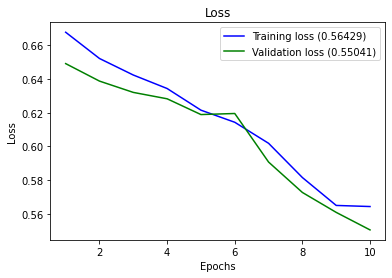

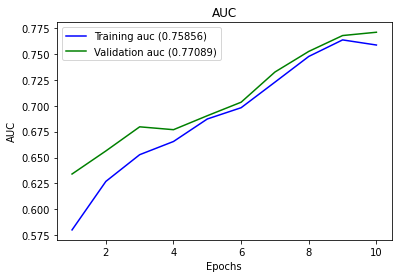

38/38 [==============================] - 0s 4ms/step
41  from  55 /  Кронштейны для ТВ и мониторов
Epoch 1/10
21/21 [==============================] - 2s 35ms/step - loss: 0.4638 - auc_40: 0.5923 - val_loss: 0.4275 - val_auc_40: 0.6948
Epoch 2/10
21/21 [==============================] - 0s 20ms/step - loss: 0.4163 - auc_40: 0.6744 - val_loss: 0.4297 - val_auc_40: 0.6746
Epoch 3/10
21/21 [==============================] - 0s 17ms/step - loss: 0.4010 - auc_40: 0.7322 - val_loss: 0.4311 - val_auc_40: 0.6726


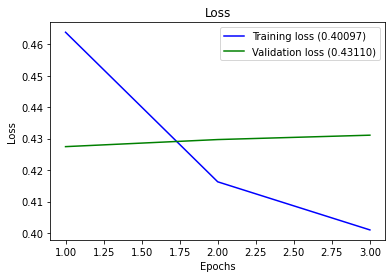

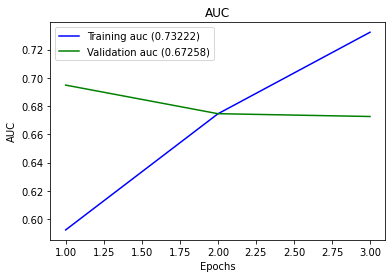

6/6 [==============================] - 0s 4ms/step
42  from  55 /  Процессор
Epoch 1/10
35/35 [==============================] - 2s 25ms/step - loss: 0.6842 - auc_41: 0.5295 - val_loss: 0.6812 - val_auc_41: 0.5358
Epoch 2/10
35/35 [==============================] - 1s 16ms/step - loss: 0.6748 - auc_41: 0.5737 - val_loss: 0.6824 - val_auc_41: 0.5324
Epoch 3/10
35/35 [==============================] - 1s 16ms/step - loss: 0.6695 - auc_41: 0.5920 - val_loss: 0.6862 - val_auc_41: 0.5462


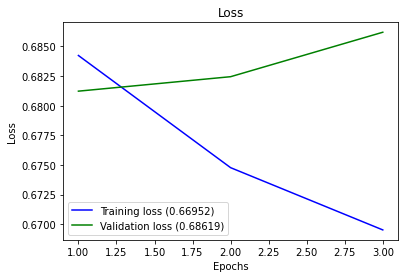

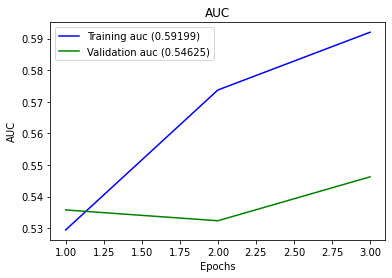

9/9 [==============================] - 0s 4ms/step
43  from  55 /  Ремешок для смарт-часов
Epoch 1/10
60/60 [==============================] - 2s 21ms/step - loss: 0.6802 - auc_42: 0.5808 - val_loss: 0.6319 - val_auc_42: 0.6911
Epoch 2/10
60/60 [==============================] - 1s 15ms/step - loss: 0.6517 - auc_42: 0.6499 - val_loss: 0.6452 - val_auc_42: 0.6940
Epoch 3/10
60/60 [==============================] - 1s 15ms/step - loss: 0.6359 - auc_42: 0.6767 - val_loss: 0.6077 - val_auc_42: 0.7230
Epoch 4/10
60/60 [==============================] - 1s 15ms/step - loss: 0.6264 - auc_42: 0.6939 - val_loss: 0.6269 - val_auc_42: 0.7121
Epoch 5/10
60/60 [==============================] - 1s 15ms/step - loss: 0.6098 - auc_42: 0.7196 - val_loss: 0.6102 - val_auc_42: 0.7128


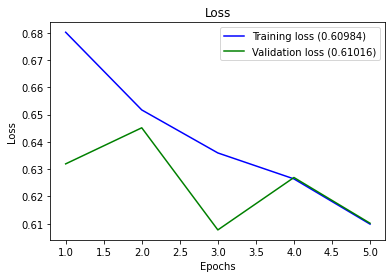

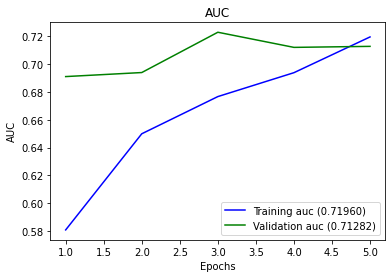

16/16 [==============================] - 0s 4ms/step
44  from  55 /  Блок питания компьютера
Epoch 1/10
23/23 [==============================] - 1s 30ms/step - loss: 0.5997 - auc_43: 0.5043 - val_loss: 0.5475 - val_auc_43: 0.5582
Epoch 2/10
23/23 [==============================] - 0s 16ms/step - loss: 0.5372 - auc_43: 0.5573 - val_loss: 0.5284 - val_auc_43: 0.6096
Epoch 3/10
23/23 [==============================] - 0s 16ms/step - loss: 0.5240 - auc_43: 0.6420 - val_loss: 0.5194 - val_auc_43: 0.6354
Epoch 4/10
23/23 [==============================] - 0s 17ms/step - loss: 0.5176 - auc_43: 0.6492 - val_loss: 0.5158 - val_auc_43: 0.6475
Epoch 5/10
23/23 [==============================] - 0s 17ms/step - loss: 0.5066 - auc_43: 0.6868 - val_loss: 0.5370 - val_auc_43: 0.6280
Epoch 6/10
23/23 [==============================] - 0s 17ms/step - loss: 0.5012 - auc_43: 0.6970 - val_loss: 0.5193 - val_auc_43: 0.6838


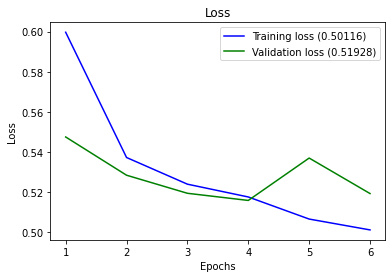

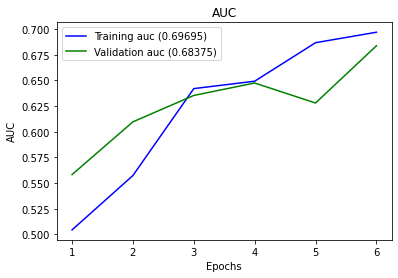

6/6 [==============================] - 0s 4ms/step
45  from  55 /  Компьютерный корпус
Epoch 1/10
14/14 [==============================] - 1s 41ms/step - loss: 0.7373 - auc_44: 0.5034 - val_loss: 0.6619 - val_auc_44: 0.5000
Epoch 2/10
14/14 [==============================] - 0s 18ms/step - loss: 0.6488 - auc_44: 0.4982 - val_loss: 0.6356 - val_auc_44: 0.5000
Epoch 3/10
14/14 [==============================] - 0s 17ms/step - loss: 0.6243 - auc_44: 0.5152 - val_loss: 0.6139 - val_auc_44: 0.5000
Epoch 4/10
14/14 [==============================] - 0s 17ms/step - loss: 0.6044 - auc_44: 0.5018 - val_loss: 0.5965 - val_auc_44: 0.5000
Epoch 5/10
14/14 [==============================] - 0s 18ms/step - loss: 0.5885 - auc_44: 0.5058 - val_loss: 0.5830 - val_auc_44: 0.5000
Epoch 6/10
14/14 [==============================] - 0s 18ms/step - loss: 0.5763 - auc_44: 0.5143 - val_loss: 0.5726 - val_auc_44: 0.5000
Epoch 7/10
14/14 [==============================] - 0s 18ms/step - loss: 0.5669 - auc_44: 0

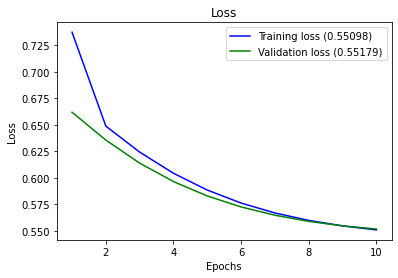

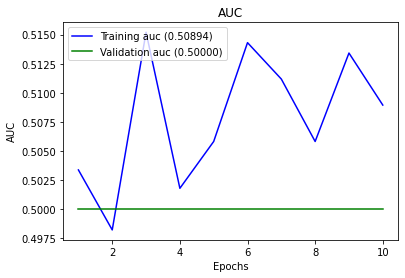

4/4 [==============================] - 0s 4ms/step
46  from  55 /  Карта памяти
Epoch 1/10
44/44 [==============================] - 2s 23ms/step - loss: 0.6395 - auc_45: 0.6816 - val_loss: 0.6183 - val_auc_45: 0.7142
Epoch 2/10
44/44 [==============================] - 1s 16ms/step - loss: 0.5677 - auc_45: 0.7747 - val_loss: 0.5840 - val_auc_45: 0.7660
Epoch 3/10
44/44 [==============================] - 1s 16ms/step - loss: 0.5387 - auc_45: 0.8019 - val_loss: 0.5649 - val_auc_45: 0.7811
Epoch 4/10
44/44 [==============================] - 1s 16ms/step - loss: 0.5119 - auc_45: 0.8268 - val_loss: 0.5594 - val_auc_45: 0.7896
Epoch 5/10
44/44 [==============================] - 1s 16ms/step - loss: 0.4913 - auc_45: 0.8417 - val_loss: 0.5855 - val_auc_45: 0.7799
Epoch 6/10
44/44 [==============================] - 1s 16ms/step - loss: 0.4731 - auc_45: 0.8537 - val_loss: 0.5719 - val_auc_45: 0.7935


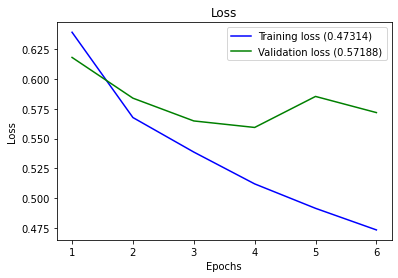

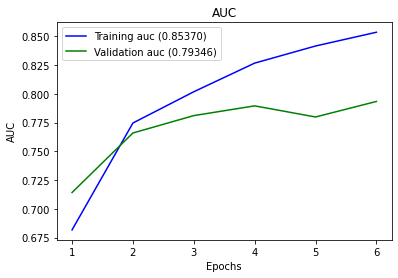

12/12 [==============================] - 0s 4ms/step
47  from  55 /  Сумка для ноутбука
Epoch 1/10
19/19 [==============================] - 1s 34ms/step - loss: 0.5838 - auc_46: 0.6653 - val_loss: 0.6566 - val_auc_46: 0.6929
Epoch 2/10
19/19 [==============================] - 0s 17ms/step - loss: 0.5354 - auc_46: 0.7284 - val_loss: 0.5605 - val_auc_46: 0.7019
Epoch 3/10
19/19 [==============================] - 0s 17ms/step - loss: 0.5057 - auc_46: 0.7717 - val_loss: 0.5575 - val_auc_46: 0.7151
Epoch 4/10
19/19 [==============================] - 0s 17ms/step - loss: 0.4878 - auc_46: 0.7874 - val_loss: 0.5614 - val_auc_46: 0.7263
Epoch 5/10
19/19 [==============================] - 0s 16ms/step - loss: 0.4716 - auc_46: 0.8040 - val_loss: 0.5565 - val_auc_46: 0.7346
Epoch 6/10
19/19 [==============================] - 0s 16ms/step - loss: 0.4516 - auc_46: 0.8246 - val_loss: 0.5513 - val_auc_46: 0.7408
Epoch 7/10
19/19 [==============================] - 0s 17ms/step - loss: 0.4404 - auc_46: 

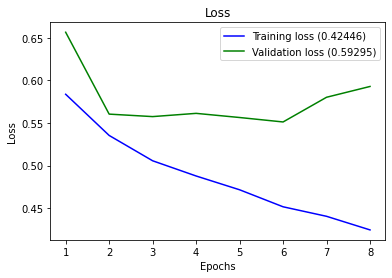

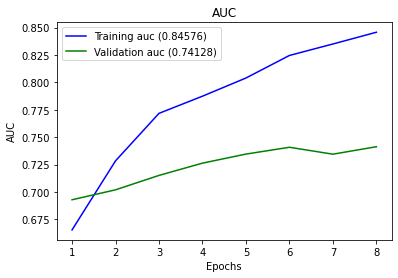

5/5 [==============================] - 0s 4ms/step
48  from  55 /  Монитор
Epoch 1/10
62/62 [==============================] - 2s 20ms/step - loss: 0.6960 - auc_47: 0.4834 - val_loss: 0.6898 - val_auc_47: 0.5054
Epoch 2/10
62/62 [==============================] - 1s 15ms/step - loss: 0.6884 - auc_47: 0.4853 - val_loss: 0.6893 - val_auc_47: 0.5020
Epoch 3/10
62/62 [==============================] - 1s 15ms/step - loss: 0.6877 - auc_47: 0.4848 - val_loss: 0.6896 - val_auc_47: 0.5030
Epoch 4/10
62/62 [==============================] - 1s 15ms/step - loss: 0.6875 - auc_47: 0.4851 - val_loss: 0.6902 - val_auc_47: 0.5030


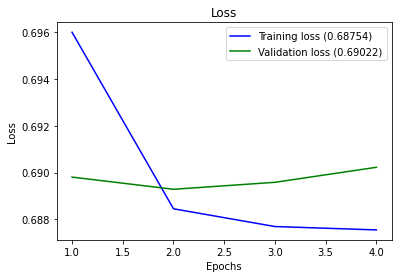

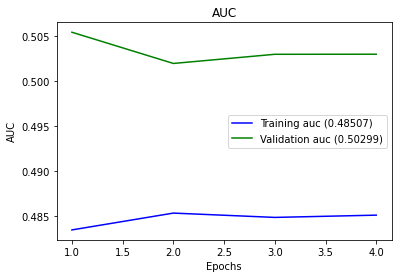

16/16 [==============================] - 0s 4ms/step
49  from  55 /  Игровые наушники
Epoch 1/10
37/37 [==============================] - 2s 24ms/step - loss: 0.4720 - auc_48: 0.5368 - val_loss: 0.4530 - val_auc_48: 0.6728
Epoch 2/10
37/37 [==============================] - 1s 16ms/step - loss: 0.4395 - auc_48: 0.6208 - val_loss: 0.4271 - val_auc_48: 0.6868
Epoch 3/10
37/37 [==============================] - 1s 16ms/step - loss: 0.4286 - auc_48: 0.6581 - val_loss: 0.4211 - val_auc_48: 0.6923
Epoch 4/10
37/37 [==============================] - 1s 15ms/step - loss: 0.4223 - auc_48: 0.6735 - val_loss: 0.4179 - val_auc_48: 0.7046
Epoch 5/10
37/37 [==============================] - 1s 16ms/step - loss: 0.4175 - auc_48: 0.6878 - val_loss: 0.4156 - val_auc_48: 0.7069
Epoch 6/10
37/37 [==============================] - 1s 16ms/step - loss: 0.4141 - auc_48: 0.6951 - val_loss: 0.4211 - val_auc_48: 0.7048
Epoch 7/10
37/37 [==============================] - 1s 15ms/step - loss: 0.4060 - auc_48: 0.

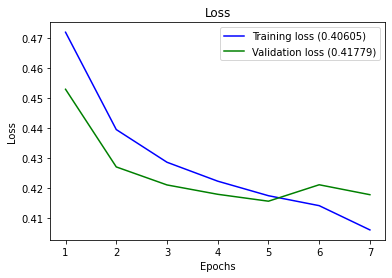

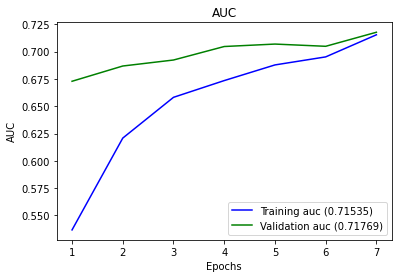

10/10 [==============================] - 0s 4ms/step
50  from  55 /  Видеорегистратор
Epoch 1/10
39/39 [==============================] - 2s 24ms/step - loss: 0.4775 - auc_49: 0.6231 - val_loss: 0.4590 - val_auc_49: 0.6955
Epoch 2/10
39/39 [==============================] - 1s 15ms/step - loss: 0.4574 - auc_49: 0.6591 - val_loss: 0.4484 - val_auc_49: 0.7020
Epoch 3/10
39/39 [==============================] - 1s 15ms/step - loss: 0.4429 - auc_49: 0.6765 - val_loss: 0.4382 - val_auc_49: 0.7097
Epoch 4/10
39/39 [==============================] - 1s 16ms/step - loss: 0.4316 - auc_49: 0.7099 - val_loss: 0.4384 - val_auc_49: 0.7074
Epoch 5/10
39/39 [==============================] - 1s 16ms/step - loss: 0.4289 - auc_49: 0.7163 - val_loss: 0.4450 - val_auc_49: 0.7002


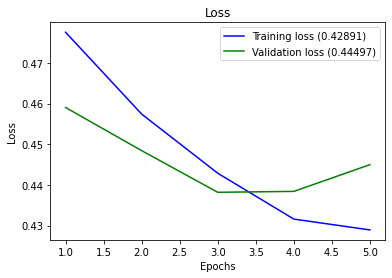

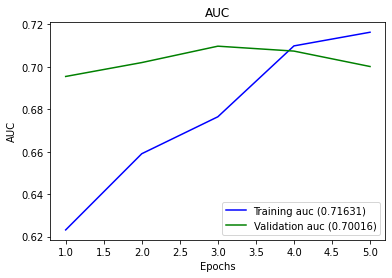

10/10 [==============================] - 0s 4ms/step
51  from  55 /  Микрофон
Epoch 1/10
26/26 [==============================] - 2s 28ms/step - loss: 0.5308 - auc_50: 0.5891 - val_loss: 0.4824 - val_auc_50: 0.6638
Epoch 2/10
26/26 [==============================] - 0s 16ms/step - loss: 0.4656 - auc_50: 0.7144 - val_loss: 0.4750 - val_auc_50: 0.6733
Epoch 3/10
26/26 [==============================] - 0s 16ms/step - loss: 0.4398 - auc_50: 0.7586 - val_loss: 0.4641 - val_auc_50: 0.6991
Epoch 4/10
26/26 [==============================] - 0s 16ms/step - loss: 0.4160 - auc_50: 0.8010 - val_loss: 0.4678 - val_auc_50: 0.6974
Epoch 5/10
26/26 [==============================] - 0s 16ms/step - loss: 0.4044 - auc_50: 0.8174 - val_loss: 0.4792 - val_auc_50: 0.7022


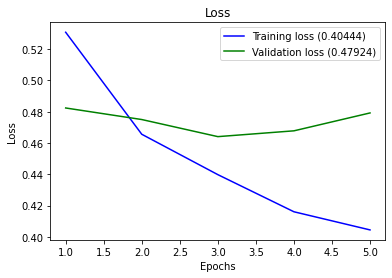

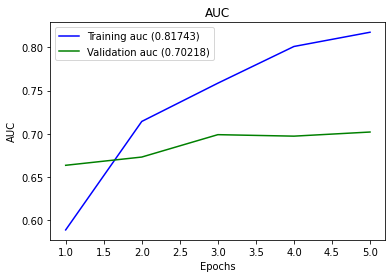

7/7 [==============================] - 0s 4ms/step
52  from  55 /  Аккумулятор для ноутбука
Epoch 1/10
38/38 [==============================] - 2s 24ms/step - loss: 0.6318 - auc_51: 0.6664 - val_loss: 0.6070 - val_auc_51: 0.7149
Epoch 2/10
38/38 [==============================] - 1s 16ms/step - loss: 0.5910 - auc_51: 0.7259 - val_loss: 0.6038 - val_auc_51: 0.7237
Epoch 3/10
38/38 [==============================] - 1s 16ms/step - loss: 0.5789 - auc_51: 0.7436 - val_loss: 0.5921 - val_auc_51: 0.7375
Epoch 4/10
38/38 [==============================] - 1s 16ms/step - loss: 0.5663 - auc_51: 0.7586 - val_loss: 0.5934 - val_auc_51: 0.7386
Epoch 5/10
38/38 [==============================] - 1s 15ms/step - loss: 0.5524 - auc_51: 0.7744 - val_loss: 0.5938 - val_auc_51: 0.7362


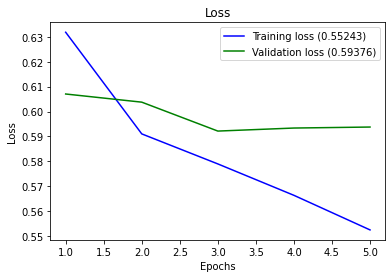

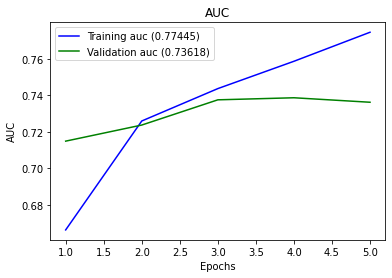

10/10 [==============================] - 0s 4ms/step
53  from  55 /  ИБП
Epoch 1/10
33/33 [==============================] - 2s 26ms/step - loss: 0.5720 - auc_52: 0.5954 - val_loss: 0.4918 - val_auc_52: 0.7615
Epoch 2/10
33/33 [==============================] - 1s 16ms/step - loss: 0.5255 - auc_52: 0.6969 - val_loss: 0.5023 - val_auc_52: 0.7682
Epoch 3/10
33/33 [==============================] - 1s 16ms/step - loss: 0.5185 - auc_52: 0.7112 - val_loss: 0.5035 - val_auc_52: 0.7485


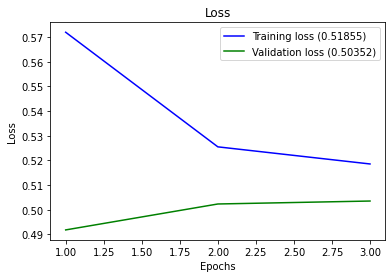

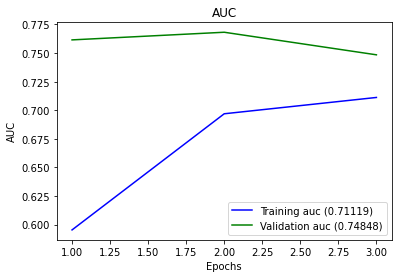

9/9 [==============================] - 0s 4ms/step
54  from  55 /  Кулер
Epoch 1/10
23/23 [==============================] - 1s 30ms/step - loss: 0.6242 - auc_53: 0.5963 - val_loss: 0.5959 - val_auc_53: 0.6280
Epoch 2/10
23/23 [==============================] - 0s 16ms/step - loss: 0.5559 - auc_53: 0.7070 - val_loss: 0.5682 - val_auc_53: 0.6482
Epoch 3/10
23/23 [==============================] - 0s 17ms/step - loss: 0.5243 - auc_53: 0.7400 - val_loss: 0.5713 - val_auc_53: 0.6466
Epoch 4/10
23/23 [==============================] - 0s 16ms/step - loss: 0.5021 - auc_53: 0.7715 - val_loss: 0.5658 - val_auc_53: 0.6589
Epoch 5/10
23/23 [==============================] - 0s 16ms/step - loss: 0.4911 - auc_53: 0.7875 - val_loss: 0.5603 - val_auc_53: 0.6790
Epoch 6/10
23/23 [==============================] - 0s 16ms/step - loss: 0.4745 - auc_53: 0.8008 - val_loss: 0.5614 - val_auc_53: 0.6766
Epoch 7/10
23/23 [==============================] - 0s 16ms/step - loss: 0.4576 - auc_53: 0.8183 - val_lo

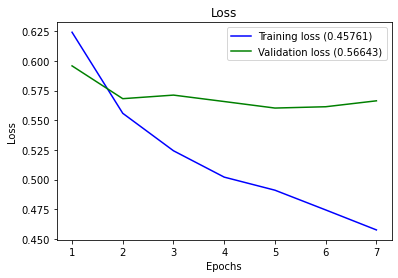

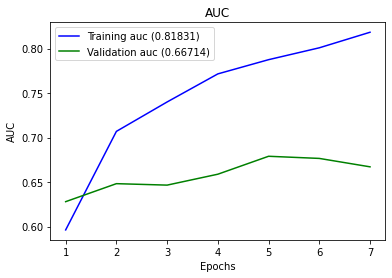

6/6 [==============================] - 0s 4ms/step
55  from  55 /  Фотофон
Epoch 1/10
12/12 [==============================] - 1s 47ms/step - loss: 0.3441 - auc_54: 0.6342 - val_loss: 0.2983 - val_auc_54: 0.6989
Epoch 2/10
12/12 [==============================] - 0s 20ms/step - loss: 0.2751 - auc_54: 0.7561 - val_loss: 0.3004 - val_auc_54: 0.6812
Epoch 3/10
12/12 [==============================] - 0s 19ms/step - loss: 0.2411 - auc_54: 0.8459 - val_loss: 0.3037 - val_auc_54: 0.6844


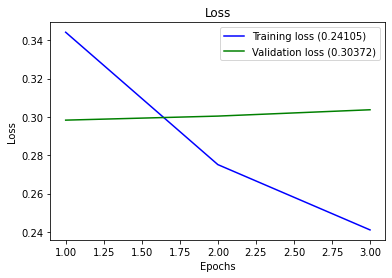

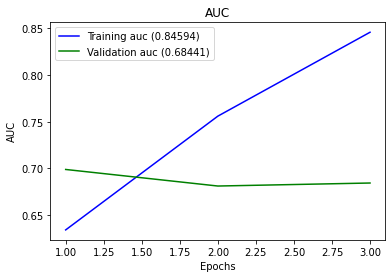

4/4 [==============================] - 0s 5ms/step
CPU times: total: 32min 19s
Wall time: 17min 44s


,cat,precission,recall,f1
0,Микроскоп,0.848624,0.822222,0.835214
1,Зарядные устройства и док-станции,0.639175,0.691450,0.664286
2,Принтеры и МФУ,0.749403,0.951515,0.838451
3,Защитная пленка,0.000000,0.000000,0.000000
4,Смартфон,0.665714,0.595690,0.628759
5,"Жесткие диски, SSD и сетевые накопители",0.775510,0.748031,0.761523
6,rest,0.767903,0.784487,0.776106
7,Устройство ручного ввода,0.798786,0.836512,0.817214
8,Портативная акустическая система,0.890443,1.000000,0.942047
9,Мобильный телефон,0.651163,0.982456,0.783217


In [68]:
%%time
pr = []
rec = []
f1 = []
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

for i, cat in enumerate(all_categories):
    print(i+1, ' from ', len(all_categories), '/ ', cat)
    idxs_te = indexes(X_test, cat)
    EPOCHS = 10
    h = mm_models[cat].fit(mm_models_ds[cat][0], epochs = EPOCHS, validation_data=mm_models_ds[cat][1], callbacks=[callback])
    plot_history(h.history)
    predictions_sp = mm_models[cat].predict(mm_models_ds[cat][1])
    predictions_sp.resize(len(predictions_sp))
    pred_sp = (predictions_sp>0.5)*1
    pr.append(precision_score(y_test.iloc[idxs_te], pred_sp))
    rec.append(recall_score(y_test.iloc[idxs_te], pred_sp))
    f1.append(f1_score(y_test.iloc[idxs_te], pred_sp))
    
pd.DataFrame(data = {'cat':all_categories, 'precission':pr, 'recall':rec, 'f1':f1})

___

## Avg of 3

In [67]:
importlib.reload(voting)

<module 'voting' from 'C:\\Users\\Rufennec\\DS\\hackaton\\voting.py'>

In [45]:
def indexes(df, cat):
    idx = np.sort(np.where(df['categories'] == cat)[0])
    return idx.astype(int)

In [46]:
def vetorizer_creator(df):
        vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+[-.]*\w+\b')
        vectorizer.fit(pd.concat([df['tfidf_1'],df['tfidf_2']]))
        return vectorizer

In [47]:
def tfidf_ds(df, tfidf_1, tfidf_2, vectorizer):
    tfidf_1_vectorized = vectorizer.transform(df[tfidf_1])
    tfidf_2_vectorized = vectorizer.transform(df[tfidf_2])
    return tfidf_1_vectorized + tfidf_2_vectorized

### __tfidf models

In [52]:
tfidf_cols = ['tfidf_1','tfidf_2']
mm_cols = ['main_pic_embeddings_resnet_v1', 'main_pic_embeddings_resnet_v1_2', 'name_bert_64', 'name_bert_64_2', 'similar', 'opposite', 'single']
attr_cols = attr_cols

In [53]:
%%time

# подотовка tfidf моделей
tfidf_models = {}
tfidf_vectzrs = {}
for i, cat in enumerate(all_categories):
    #---status bar
    sys.stdout.write('\r Прогресс: {0}/{1}'.format(i+1,len(all_categories)))
    sys.stdout.flush()
    #-----
    idx = indexes(X_train, cat)
    tfidf_vectzrs[cat] = vetorizer_creator(X_train.iloc[idx])
    
    tfidf_models[cat] = LGBMClassifier(n_estimators = 500, class_weight = 'balanced', max_depth = 15)
    X_sparse = tfidf_ds(X_train.iloc[idx], tfidf_cols[0], tfidf_cols[1], tfidf_vectzrs[cat])     

    tfidf_models[cat].fit(X_sparse, y_train.iloc[idx])
tfidf_models['type'] = 'tfidf'
print('\n')

 Прогресс: 55/55CPU times: total: 8min 1s
Wall time: 1min 33s


### __atr models

In [44]:
attr_cols = X_train.columns[17:].to_list()

In [54]:
%%time

# подотовка attr моделей
attr_models = {}
for i, cat in enumerate(all_categories):
    #---status bar
    sys.stdout.write('\r Прогресс: {0}/{1}'.format(i+1,len(all_categories)))
    sys.stdout.flush()
    #-----

    idx = indexes(X_train, cat)

    attr_models[cat] = LGBMClassifier(n_estimators = 500, class_weight = 'balanced', max_depth = 15)
    attr_models[cat].fit(X_train.iloc[idx][attr_cols].to_numpy(), y_train.iloc[idx])
attr_models['type'] = 'attr'
print('\n')

 Прогресс: 55/55CPU times: total: 4min 41s
Wall time: 59.7 s


### Avg model

In [69]:
v = voting.voting_model([mm_models, tfidf_models, attr_models], 
                        tfidf_vectzrs,
                       [mm_cols, tfidf_cols, attr_cols],
                       all_categories)

In [70]:
%%time
val_pred = v.predict(X_test, 'soft')

___Микроскоп
___Зарядные устройства и док-станции
___Принтеры и МФУ
___Защитная пленка
___Смартфон
___Жесткие диски, SSD и сетевые накопители
___rest
___Устройство ручного ввода
___Портативная акустическая система
___Мобильный телефон
___Коммутатор
___Ноутбук
___Наушники
___Умные часы
___Батарейки и аккумуляторы
___Телевизор
___Умный дом
___Видеокарта
___Коврик для мыши
___Модуль оперативной памяти
___Чехол
___Кабель
___Матрица для ноутбука
___Картридж
___Проводные и DECT-телефоны
___Клавиатура для ноутбука
___Моноблок
___Электронные модули
___Видеодомофон
___Планшет
___Игровая приставка
___Конфигуратор ПК
___Видеонаблюдение
___Телескоп
___Маршрутизатор
___Стяжка для кабеля
___Сетевой фильтр, удлинитель, разветвитель
___Материнская плата
___Термопленка
___Запчасти для смартфонов
___Кронштейны для ТВ и мониторов
___Процессор
___Ремешок для смарт-часов
___Блок питания компьютера
___Компьютерный корпус
___Карта памяти
___Сумка для ноутбука
___Монитор
___Игровые наушники
___Видеорегистрато

In [74]:
vote_target, vote_pred = pr_auc_macro_prep(pd.concat([X_test, y_test], axis =1), val_pred)

In [71]:
pr_auc = pr_auc_macro(vote_target, vote_pred, prec_level=0.75, cat_column="cat3_grouped")
pr_auc 

pr-auc: 0.63839   Вес: 0.19643   rest
pr-auc: 0.39483   Вес: 0.00165   Автоматика для ворот
pr-auc: 0.47099   Вес: 0.00502   Аккумулятор для ноутбука
pr-auc: 0.79504   Вес: 0.00727   Аккумулятор для телефона
pr-auc: 0.53704   Вес: 0.00626   Аккумуляторная батарейка
pr-auc: 0.77893   Вес: 0.00504   Батарейка
pr-auc: 0.29920   Вес: 0.00284   Батарея для пылесоса
pr-auc: 0.90921   Вес: 0.00302   Блок питания компьютера
pr-auc: 0.81934   Вес: 0.00268   Видеодомофон
pr-auc: 0.62486   Вес: 0.00923   Видеокарта
pr-auc: 0.88192   Вес: 0.00450   Видеорегистратор
pr-auc: 0.71205   Вес: 0.00579   Внешний HDD
pr-auc: 0.90753   Вес: 0.00346   Внешний аккумулятор
pr-auc: 0.51954   Вес: 0.00595   Внутренний HDD
pr-auc: 0.86094   Вес: 0.00878   Внутренний SSD
pr-auc: 0.61946   Вес: 0.01851   Запчасти для телефонов
pr-auc: 0.68761   Вес: 0.00473   Зарядное устройство
pr-auc: 0.09569   Вес: 0.00985   Защитная пленка
pr-auc: 0.92110   Вес: 0.00444   ИБП
pr-auc: 0.98684   Вес: 0.04521   Игровая приставка


0.6142769488961147

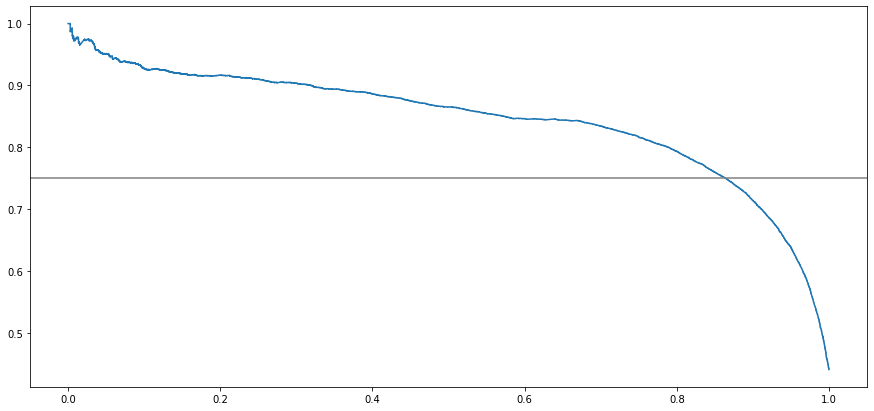

In [76]:
precision, recall, thrs = precision_recall_curve(vote_target["target"], vote_pred["scores"])
fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

### --submit

In [77]:
sybmit_vote_pred = v.predict(test_pairs, 'soft')

___Микроскоп
___Зарядные устройства и док-станции
___Принтеры и МФУ
___Защитная пленка
___Смартфон
___Жесткие диски, SSD и сетевые накопители
___rest
___Устройство ручного ввода
___Портативная акустическая система
___Мобильный телефон
___Коммутатор
___Ноутбук
___Наушники
___Умные часы
___Батарейки и аккумуляторы
___Телевизор
___Умный дом
___Видеокарта
___Коврик для мыши
___Модуль оперативной памяти
___Чехол
___Кабель
___Матрица для ноутбука
___Картридж
___Проводные и DECT-телефоны
___Клавиатура для ноутбука
___Моноблок
___Электронные модули
___Видеодомофон
___Планшет
___Игровая приставка
___Конфигуратор ПК
___Видеонаблюдение
___Телескоп
___Маршрутизатор
___Стяжка для кабеля
___Сетевой фильтр, удлинитель, разветвитель
___Материнская плата
___Термопленка
___Запчасти для смартфонов
___Кронштейны для ТВ и мониторов
___Процессор
___Ремешок для смарт-часов
___Блок питания компьютера
___Компьютерный корпус
___Карта памяти
___Сумка для ноутбука
___Монитор
___Игровые наушники
___Видеорегистрато

In [78]:
submit_prep(test_pairs, sybmit_vote_pred).to_csv('e:\\ds\\hackaton\\vote_submit_4.csv', index=False)

In [79]:
pd.read_csv('e:\\ds\\hackaton\\vote_submit_4.csv')

,variantid1,variantid2,target
0,52076340,290590137,0.311959
1,64525522,204128919,0.033112
2,77243372,479860557,0.439899
3,86065820,540678372,0.806655
4,91566575,258840506,0.322885
...,...,...,...
18079,666998614,667074522,0.058712
18080,670036240,670048449,0.414054
18081,670284509,684323809,0.704329
18082,692172005,704805270,0.622671


===

___